# P5: Identify Fraud from Enron Email

## 0. Code library

### 0.1 Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%matplotlib inline

In [4]:
%load_ext rpy2.ipython

In [5]:
%R library(devtools)

array(['devtools', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='|S9')

In [6]:
%R library(ggplot2)

array(['ggplot2', 'devtools', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], 
      dtype='|S9')

In [7]:
%R library(corrplot)

array(['corrplot', 'ggplot2', 'devtools', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='|S9')

In [8]:
%R library(repr)

array(['repr', 'corrplot', 'ggplot2', 'devtools', 'tools', 'stats',
       'graphics', 'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='|S9')

In [9]:
import numpy as np

In [10]:
import pandas as pd

In [11]:
import pickle

In [12]:
import sys

In [13]:
import scipy

In [14]:
import matplotlib 

In [15]:
import pylab

In [16]:
from IPython.display import HTML

In [17]:
matplotlib.style.reload_library()

In [18]:
import matplotlib.pyplot as plt

In [19]:
from functools import partial

In [20]:
from sklearn.preprocessing import Imputer

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
from sklearn.cross_validation import train_test_split

In [24]:
from sklearn.cross_validation import StratifiedShuffleSplit

### 0.2 Functions

In [25]:
hide_code = ''
HTML('''<script>
code_show = true; 
function code_display() {
  if (code_show) {
    $('div.input').each(function(id) {
      if (id == 0 || $(this).html().indexOf('hide_code') > -1) {
        $(this).hide();
      }
    });
    $('div.output_prompt').css('opacity', 0);
  } else {
    $('div.input').each(function(id) {
      $(this).show();
    });
    $('div.output_prompt').css('opacity', 1);
  }
  code_show = !code_show
} 
$( document ).ready(code_display);
</script>
<form action="javascript: code_display()"><input style="opacity: 100" type="submit" 
value="Click to show or to hide code cells"></form>''')

For displaying or hiding the code cells with programs and functions, the reader of the project can use the button "Click to show or to hide code cells" on the top.

In [26]:
hide_code
# finction for reading a dictionary as a dataframe
def dict_to_dataframe(dictionary):

    df = pd.DataFrame.from_dict(dictionary).transpose()
    df.apply(partial(pd.to_numeric, errors='ignore'))

    df.reset_index(level=0, inplace=True)
    columns = list(df.columns)
    columns[0] = 'staff_name'
    df.columns = columns
    
    return(df)

In [27]:
hide_code
# function for counting 'NaN' values without replacing
def count_nan(column):
    k = 0
    for value in column:
        if value == 'NaN':
            k += 1
    p = 100.0*k/len(column)
    return k, p

In [28]:
hide_code
# function for cleaning 'NaN' values without replacing
def column_without_nan(column):
    data = []
    for value in column:
        if value == 'NaN':
            continue
        data.append(value)
    return data

In [29]:
hide_code
# function for cleaning 'NaN' values with replacing
def column_with_npnan(column):
    data = []
    for value in column:
        if value == 'NaN':
            value = np.nan
        data.append(value)
    return np.array(data)

In [30]:
hide_code
# function for displaying 3 top values
def show_three_top(data, feature):
    print "three largest", feature, ":"
    sorted_list = sorted(column_without_nan(data[feature]), reverse=True)[0:3]
    return sorted_list

### 0.3 Fragments of starter code

You can see the set of useful functions from the Udacity course "INTRO TO MACHINE LEARNING" after clicking the button above.

In [31]:
hide_code
def featureFormat( dictionary, features, remove_NaN=True, 
                  remove_all_zeroes=True, remove_any_zeroes=False, sort_keys = False):
    return_list = []

    # Key order - first branch is for Python 3 compatibility on mini-projects,
    # second branch is for compatibility on final project.
    if isinstance(sort_keys, str):
        keys = pickle.load(open(sort_keys, "rb"))
    elif sort_keys:
        keys = sorted(dictionary.keys())
    else:
        keys = dictionary.keys()

    for key in keys:
        tmp_list = []
        for feature in features:
            try:
                dictionary[key][feature]
            except KeyError:
                print "error: key ", feature, " not present"
                return
            value = dictionary[key][feature]
            if value=="NaN" and remove_NaN:
                value = 0
            tmp_list.append( float(value) )
        # Logic for deciding whether or not to add the data point.
        append = True
        # exclude 'poi' class as criteria.
        if features[0] == 'poi':
            test_list = tmp_list[1:]
        else:
            test_list = tmp_list
        ### if all features are zero and you want to remove
        ### data points that are all zero, do that here
        if remove_all_zeroes:
            append = False
            for item in test_list:
                if item != 0 and item != "NaN":
                    append = True
                    break
        ### if any features for a given data point are zero
        ### and you want to remove data points with any zeroes,
        ### handle that here
        if remove_any_zeroes:
            if 0 in test_list or "NaN" in test_list:
                append = False
        ### Append the data point if flagged for addition.
        if append:
            return_list.append( np.array(tmp_list) )

    return np.array(return_list)            

In [32]:
hide_code
def targetFeatureSplit( data ):
    target = []
    features = []
    for item in data:
        target.append( item[0] )
        features.append( item[1:] )

    return target, features

In [33]:
hide_code
PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"
CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

In [34]:
hide_code
def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

In [35]:
hide_code
def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

In [36]:
hide_code
def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

In [37]:
hide_code
def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

## 1. Resources

### 1.1 The starter code
https://github.com/udacity/ud120-projects.git

### 1.2 The dataset for the project
final_project_dataset.pkl

### 1.3 Data description
enron61702insiderpay.pdf

### 1.4 The button for hiding or displaying code cells:

https://jaycode.github.io/enron/identifying-fraud-from-enron-email.html

## 2. Data

### 2.1 The database description
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, we will play detective, and put our new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist us in our detective work, the authors have combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

### 2.2 Characteristics

The database has been loaded from the file "final_project_dataset.pkl".

In [39]:
hide_code
enron_data = pickle.load(open("final_project_dataset.pkl", "r"))

In [40]:
hide_code
print "The lenght of the dataset: ", len(enron_data)

The lenght of the dataset:  146


In [41]:
hide_code
print "The first element in the dictionary: ", next(enron_data.__iter__())

The first element in the dictionary:  METTS MARK


In [42]:
hide_code
print "The example of features in the dictionary: ", str(enron_data.itervalues().next())

The example of features in the dictionary:  {'salary': 365788, 'to_messages': 807, 'deferral_payments': 'NaN', 'total_payments': 1061827, 'exercised_stock_options': 'NaN', 'bonus': 600000, 'restricted_stock': 585062, 'shared_receipt_with_poi': 702, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 585062, 'expenses': 94299, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 1740, 'from_this_person_to_poi': 1, 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'mark.metts@enron.com', 'from_poi_to_this_person': 38}


In [43]:
hide_code
print "The length of each element: ", len(enron_data['METTS MARK'])

The length of each element:  21


In [44]:
hide_code
print "The staff list: ", str(sorted(enron_data.keys()))

The staff list:  ['ALLEN PHILLIP K', 'BADUM JAMES P', 'BANNANTINE JAMES M', 'BAXTER JOHN C', 'BAY FRANKLIN R', 'BAZELIDES PHILIP J', 'BECK SALLY W', 'BELDEN TIMOTHY N', 'BELFER ROBERT', 'BERBERIAN DAVID', 'BERGSIEKER RICHARD P', 'BHATNAGAR SANJAY', 'BIBI PHILIPPE A', 'BLACHMAN JEREMY M', 'BLAKE JR. NORMAN P', 'BOWEN JR RAYMOND M', 'BROWN MICHAEL', 'BUCHANAN HAROLD G', 'BUTTS ROBERT H', 'BUY RICHARD B', 'CALGER CHRISTOPHER F', 'CARTER REBECCA C', 'CAUSEY RICHARD A', 'CHAN RONNIE', 'CHRISTODOULOU DIOMEDES', 'CLINE KENNETH W', 'COLWELL WESLEY', 'CORDES WILLIAM R', 'COX DAVID', 'CUMBERLAND MICHAEL S', 'DEFFNER JOSEPH M', 'DELAINEY DAVID W', 'DERRICK JR. JAMES V', 'DETMERING TIMOTHY J', 'DIETRICH JANET R', 'DIMICHELE RICHARD G', 'DODSON KEITH', 'DONAHUE JR JEFFREY M', 'DUNCAN JOHN H', 'DURAN WILLIAM D', 'ECHOLS JOHN B', 'ELLIOTT STEVEN', 'FALLON JAMES B', 'FASTOW ANDREW S', 'FITZGERALD JAY L', 'FOWLER PEGGY', 'FOY JOE', 'FREVERT MARK A', 'FUGH JOHN L', 'GAHN ROBERT S', 'GARLAND C KEVIN', 'G

In [45]:
hide_code
# Get names and count the persons of interest
k_poi=0
poi = []
for i in range(len(enron_data.keys())):
    person = enron_data.keys()[i]
    if enron_data[person]['poi'] == True:
        k_poi += 1
        poi.append(person)
print "Persons of interest:", k_poi
print str(poi)

Persons of interest: 18
['HANNON KEVIN P', 'COLWELL WESLEY', 'RIEKER PAULA H', 'KOPPER MICHAEL J', 'SHELBY REX', 'DELAINEY DAVID W', 'LAY KENNETH L', 'BOWEN JR RAYMOND M', 'BELDEN TIMOTHY N', 'FASTOW ANDREW S', 'CALGER CHRISTOPHER F', 'RICE KENNETH D', 'SKILLING JEFFREY K', 'YEAGER F SCOTT', 'HIRKO JOSEPH', 'KOENIG MARK E', 'CAUSEY RICHARD A', 'GLISAN JR BEN F']


### 2.3 Summary

The dataset consists of 146 data points with 21 features. 18 records are labeled as persons of interest.

### 2.4 The features in the data
financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars).

email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string).

POI label: [‘poi’] (boolean, represented as integer).

##### Definitions (financial features):

(salary) Reflects items such as base salary, executive cash allowances, and benefits payments.

(bonus) Reflects annual cash incentives paid based upon company performance. Also may include other retention payments.

(long_term_incentive) Reflects long-term incentive cash payments from various long-term incentive programs designed to tie executive compensation to long-term success as measured
against key performance drivers and business objectives over a multi-year period, generally 3 to 5 years​.

(deferred_income) Reflects voluntary executive deferrals of salary, annual cash incentives, and long-term cash incentives as well as cash fees deferred by non-employee directors
under a deferred compensation arrangement. May also reflect deferrals under a stock option or phantom stock unit in lieu of cash arrangement. 

(deferral_payments) Reflects distributions from a deferred compensation arrangement due to termination of employment or due to in-service withdrawals as per plan provisions.

(loan_advances) Reflects total amount of loan advances, excluding repayments, provided by the Debtor in return for a promise of repayment. In certain instances, the terms of the
promissory notes allow for the option to repay with stock of the company.

(other) Reflects items such as payments for severance, consulting services, relocation costs, tax advances and allowances for employees on international assignment (i.e.
housing allowances, cost of living allowances, payments under Enron’s Tax Equalization Program, etc.). May also include payments provided with respect to
employment agreements, as well as imputed income amounts for such things as use of corporate aircraft. 

(expenses) Reflects reimbursements of business expenses. May include fees paid for consulting services.

(director_fees) Reflects cash payments and/or value of stock grants made in lieu of cash payments to non-employee directors.

(exercised_stock_options) Reflects amounts from exercised stock options which equal the market value in excess of the exercise price on the date the options were exercised either through
cashless (same-day sale), stock swap or cash exercises. The reflected gain may differ from that realized by the insider due to fluctuations in the market price and
the timing of any subsequent sale of the securities.

(restricted_stock) Reflects the gross fair market value of shares and accrued dividends (and/or phantom units and dividend equivalents) on the date of release due to lapse of vesting
periods, regardless of whether deferred.

(restricted_stock_deferred) Reflects value of restricted stock voluntarily deferred prior to release under a deferred compensation arrangement.

(total_stock_value) In 1998, 1999 and 2000, Debtor and non-debtor affiliates were charged for options granted. The Black-Scholes method was used to determine the amount to be
charged. Any amounts charged to Debtor and non-debtor affiliates associated with the options exercised related to these three years have not been subtracted
from the share value amounts shown.

## 3. The work through the project

### 3.1 Steps

Reading the data and cleaning it.

Exploring and understanding the input data.

Analyzing how best to present the data to the algorithm.

Choosing the right model and algorithm.

Measuring the performance correctly.

### 3.2 Data frame

Constructing a dataframe from a dictionary can be useful in the researching. So enron_df was created from enron_data and here is an example of rows in the dataset.

In [46]:
hide_code
# Construct the dataframe from the dictionary
enron_df = dict_to_dataframe(enron_data)

In [47]:
hide_code
# Display five records in a suitable form
enron_df.head().transpose()

,0,1,2,3,4
staff_name,ALLEN PHILLIP K,BADUM JAMES P,BANNANTINE JAMES M,BAXTER JOHN C,BAY FRANKLIN R
bonus,4175000,NaN,NaN,1200000,400000
deferral_payments,2869717,178980,NaN,1295738,260455
deferred_income,-3081055,NaN,-5104,-1386055,-201641
director_fees,NaN,NaN,NaN,NaN,NaN
email_address,phillip.allen@enron.com,NaN,james.bannantine@enron.com,NaN,frank.bay@enron.com
exercised_stock_options,1729541,257817,4046157,6680544,NaN
expenses,13868,3486,56301,11200,129142
from_messages,2195,NaN,29,NaN,NaN
from_poi_to_this_person,47,NaN,39,NaN,NaN


In [48]:
import warnings
warnings.filterwarnings('ignore')

### 3.3 Data cleaning

This database contains indexes that hamper analysis: for example, a spreadsheet artifact 'TOTAL' or "NaN' values in the rows. The visualizing as a scatter plot can confirm it.

'TOTAL' was not being used in the analysis and thus removed at all.

The datasets with 'NaN' are incompatible with scikit-learn estimators. They assume that all values in an array are numerical. A basic strategy to use these datasets is to discard entire rows and/or columns containing missing values. But in our case this can be a reason of losing data which may be valuable (even though incomplete). A better strategy is to impute the missing values.The Imputer class provides basic strategies for imputing missing values, either using the mean, the median or the most frequent value of the row or column in which the missing values are located. 

##### 3.3.1 Deleting a spreadsheet artifact  'TOTAL'
Before deleting:

In [49]:
hide_code
# Create columns 'staff_name', 'salary' without NaN
salary_name = enron_df[['staff_name', 'salary']]
salary_name = salary_name[salary_name['salary'] != 'NaN']

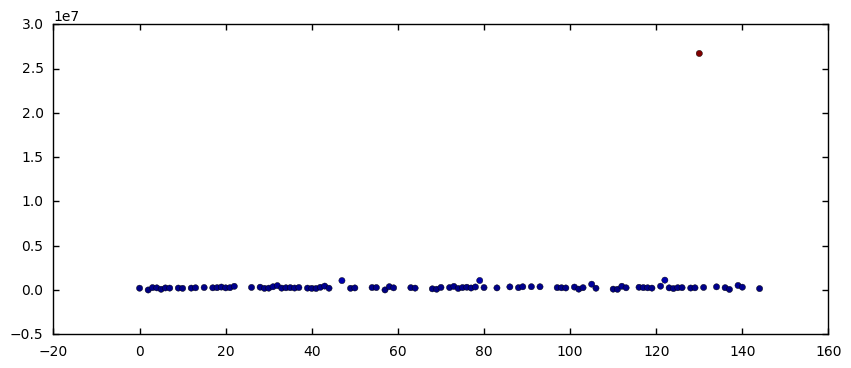

In [50]:
hide_code
# Plot columns 'staff_name', 'salary'
plt.style.use('seaborn-notebook')
plt.figure(figsize=(10,4))
x = list(salary_name['salary'].index)
plt.scatter(x, salary_name['salary'], c=salary_name['salary'], cmap='jet')

In [51]:
hide_code
# Find the name of the outlier
salary_name['staff_name'][salary_name['salary'].idxmax()]

'TOTAL'

In [52]:
hide_code
# Delete the record 'TOTAL'
del enron_data['TOTAL']
enron_df = enron_df[enron_df['staff_name'] != 'TOTAL']

After deleting:

In [53]:
hide_code
# Create columns 'staff_name', 'salary' without NaN after deleting the outlier
salary_name = enron_df[['staff_name', 'salary']]
salary_name = salary_name[salary_name['salary'] != 'NaN']

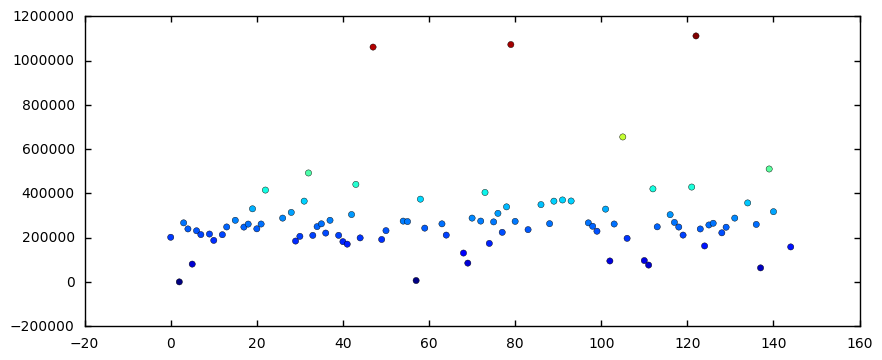

In [54]:
hide_code
# Plot columns 'staff_name', 'salary' after deleting the outlier
plt.figure(figsize=(10,4))
x = list(salary_name['salary'].index)
plt.scatter(x, salary_name['salary'], c = salary_name['salary'], cmap='jet')

##### 3.3.2 Replacing some values

Finding 2 rows with wrong values by creating the artificial variable total check as a sum of other financial variables:

In [55]:
hide_code
# Create dataframe with replaced NaN by zero
enron_df1 = pd.DataFrame(enron_df)
enron_df1 = enron_df1.convert_objects(convert_numeric=True)
enron_df1 = enron_df1.fillna(0)
# Create dataframe to check total payments
enron_df2 = pd.DataFrame()
enron_df2['staff_name'] = enron_df1['staff_name']
enron_df2['total_check'] = enron_df1['bonus'] + enron_df1['director_fees'] + enron_df1['deferral_payments'] + \
    enron_df1['deferred_income'] + enron_df1['loan_advances'] + enron_df1['long_term_incentive'] + \
    enron_df1['expenses'] + enron_df1['other'] + enron_df1['salary']
enron_df2['total_payments'] = enron_df1['total_payments']
enron_df2['stock_check'] = (enron_df1['restricted_stock'] + enron_df1['exercised_stock_options'] + \
                            enron_df1['restricted_stock_deferred'])
enron_df2['total_stock_value'] = enron_df1['total_stock_value']
enron_df2['same_total'] = (enron_df2['total_check'] == enron_df2['total_payments'])
enron_df2['same_stock'] = (enron_df2['stock_check'] == enron_df2['total_stock_value'])
enron_df2['poi'] = enron_df1['poi']
# Display results of comparing
print np.sum(enron_df2['same_total']), " are the same in total_check and total_payments from ", len(enron_df2)
print "Difference between total_check and total_payments: ", (np.sum(enron_df2['total_payments']) 
                                                              - np.sum(enron_df2['total_check']))
print 
print "Data points with difference"
print enron_df2[enron_df2['same_total'] == False]
print enron_df1[enron_df1['staff_name'].isin(enron_df2[enron_df2['same_total'] 
                                                       == False]['staff_name'].tolist())].transpose()

143  are the same in total_check and total_payments from  145
Difference between total_check and total_payments:  15382277.0

Data points with difference
          staff_name  total_check  total_payments  stock_check  \
8      BELFER ROBERT     -99215.0        102500.0      47378.0   
11  BHATNAGAR SANJAY     275728.0      15456290.0   15456290.0   

    total_stock_value same_total same_stock    poi  
8            -44093.0      False      False  False  
11                0.0      False      False  False  
                                      8                           11
staff_name                 BELFER ROBERT            BHATNAGAR SANJAY
bonus                                  0                           0
deferral_payments                -102500                           0
deferred_income                        0                           0
director_fees                       3285                      137864
email_address                        NaN  sanjay.bhatnagar@enron.com
exerc

Replacing them in the dictionary and in the dataframe:

In [56]:
hide_code
# Replacing values in 2 rows in the dictionary
enron_data['BELFER ROBERT']['deferred_income'] = -102500
enron_data['BELFER ROBERT']['deferral_payments'] = 'NaN'
enron_data['BELFER ROBERT']['director_fees'] = 102500
enron_data['BELFER ROBERT']['expenses'] = 3285
enron_data['BELFER ROBERT']['total_payments'] = 3285
enron_data['BELFER ROBERT']['exercised_stock_options'] = 'NaN'
enron_data['BELFER ROBERT']['restricted_stock'] = 44093
enron_data['BELFER ROBERT']['restricted_stock_deferred'] = -44093
enron_data['BELFER ROBERT']['total_stock_value'] = 'NaN'

enron_data['BHATNAGAR SANJAY']['director_fees'] = 'NaN'
enron_data['BHATNAGAR SANJAY']['expenses'] = 137864
enron_data['BHATNAGAR SANJAY']['other'] = 'NaN'
enron_data['BHATNAGAR SANJAY']['total_payments'] = 137864
enron_data['BHATNAGAR SANJAY']['exercised_stock_options'] = 15456290
enron_data['BHATNAGAR SANJAY']['restricted_stock'] = 2604490
enron_data['BHATNAGAR SANJAY']['restricted_stock_deferred'] = -2604490
enron_data['BHATNAGAR SANJAY']['total_stock_value'] = 15456290
# Replacing values in 2 rows in the dataframe
enron_df = dict_to_dataframe(enron_data)

In [57]:
hide_code
# Check replacing
enron_df[(enron_df['staff_name'] == 'BHATNAGAR SANJAY') | (enron_df['staff_name'] == 'BELFER ROBERT')].T

,8,11
staff_name,BELFER ROBERT,BHATNAGAR SANJAY
bonus,NaN,NaN
deferral_payments,NaN,NaN
deferred_income,-102500,NaN
director_fees,102500,NaN
email_address,NaN,sanjay.bhatnagar@enron.com
exercised_stock_options,NaN,15456290
expenses,3285,137864
from_messages,NaN,29
from_poi_to_this_person,NaN,0


##### 3.3.3 Counting NaN values
It should be noted quite a high percentage of missing data.

In [58]:
hide_code
# Create a general list of features
feature_list = ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'expenses', 
                'exercised_stock_options', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 
                'restricted_stock_deferred', 'salary', 'total_payments', 'total_stock_value',
                'to_messages', 'email_address', 'from_poi_to_this_person', 
                'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

In [59]:
hide_code
print "Counting NaN values in the dataset."
for element in feature_list:
    k, p = count_nan(enron_df[element])
    print element, ":", k, "NaN, ", "%.2f" %p, "%"

Counting NaN values in the dataset.
bonus : 64 NaN,  44.14 %
deferral_payments : 108 NaN,  74.48 %
deferred_income : 96 NaN,  66.21 %
director_fees : 130 NaN,  89.66 %
expenses : 49 NaN,  33.79 %
exercised_stock_options : 45 NaN,  31.03 %
loan_advances : 142 NaN,  97.93 %
long_term_incentive : 80 NaN,  55.17 %
other : 54 NaN,  37.24 %
restricted_stock : 35 NaN,  24.14 %
restricted_stock_deferred : 128 NaN,  88.28 %
salary : 51 NaN,  35.17 %
total_payments : 21 NaN,  14.48 %
total_stock_value : 20 NaN,  13.79 %
to_messages : 59 NaN,  40.69 %
email_address : 34 NaN,  23.45 %
from_poi_to_this_person : 59 NaN,  40.69 %
from_messages : 59 NaN,  40.69 %
from_this_person_to_poi : 59 NaN,  40.69 %
shared_receipt_with_poi : 59 NaN,  40.69 %


##### 3.3.4 Finance variables without replacement of NaN values

Let's continue to discover suspicious values. The statistical description and the histograms of all finance features can help us.

In [60]:
hide_code
# Create a list of finance features
finance_feature_list = ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options',
                        'expenses', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 
                        'restricted_stock_deferred', 'salary', 'total_payments', 'total_stock_value']
# Display statistical decription for finance features
for element in finance_feature_list:
    print element, ":", scipy.stats.describe(column_without_nan(enron_df[element]))

bonus : DescribeResult(nobs=81, minmax=(70000, 8000000), mean=1201773.0740740742, variance=2078439602903.4441, skewness=2.8973421441712133, kurtosis=8.857619044413038)
deferral_payments : DescribeResult(nobs=37, minmax=(7961, 6426990), mean=867118.81081081077, variance=1683100980644.6577, skewness=2.544038566793457, kurtosis=7.384685228696258)
deferred_income : DescribeResult(nobs=49, minmax=(-3504386, -833), mean=-571283.48979591834, variance=873691871997.255, skewness=-2.128813236641332, kurtosis=3.395194940860147)
director_fees : DescribeResult(nobs=15, minmax=(17500, 125034), mean=93234.46666666666, variance=1110227432.6952381, skewness=-1.3994021875206941, kurtosis=0.36683426754924353)
exercised_stock_options : DescribeResult(nobs=100, minmax=(9803, 34348384), mean=3117640.0, variance=32012103885457.254, skewness=3.598241974274513, kurtosis=14.274096431430213)
expenses : DescribeResult(nobs=96, minmax=(148, 228763), mean=54533.3125, variance=2182081185.5855265, skewness=1.45615510

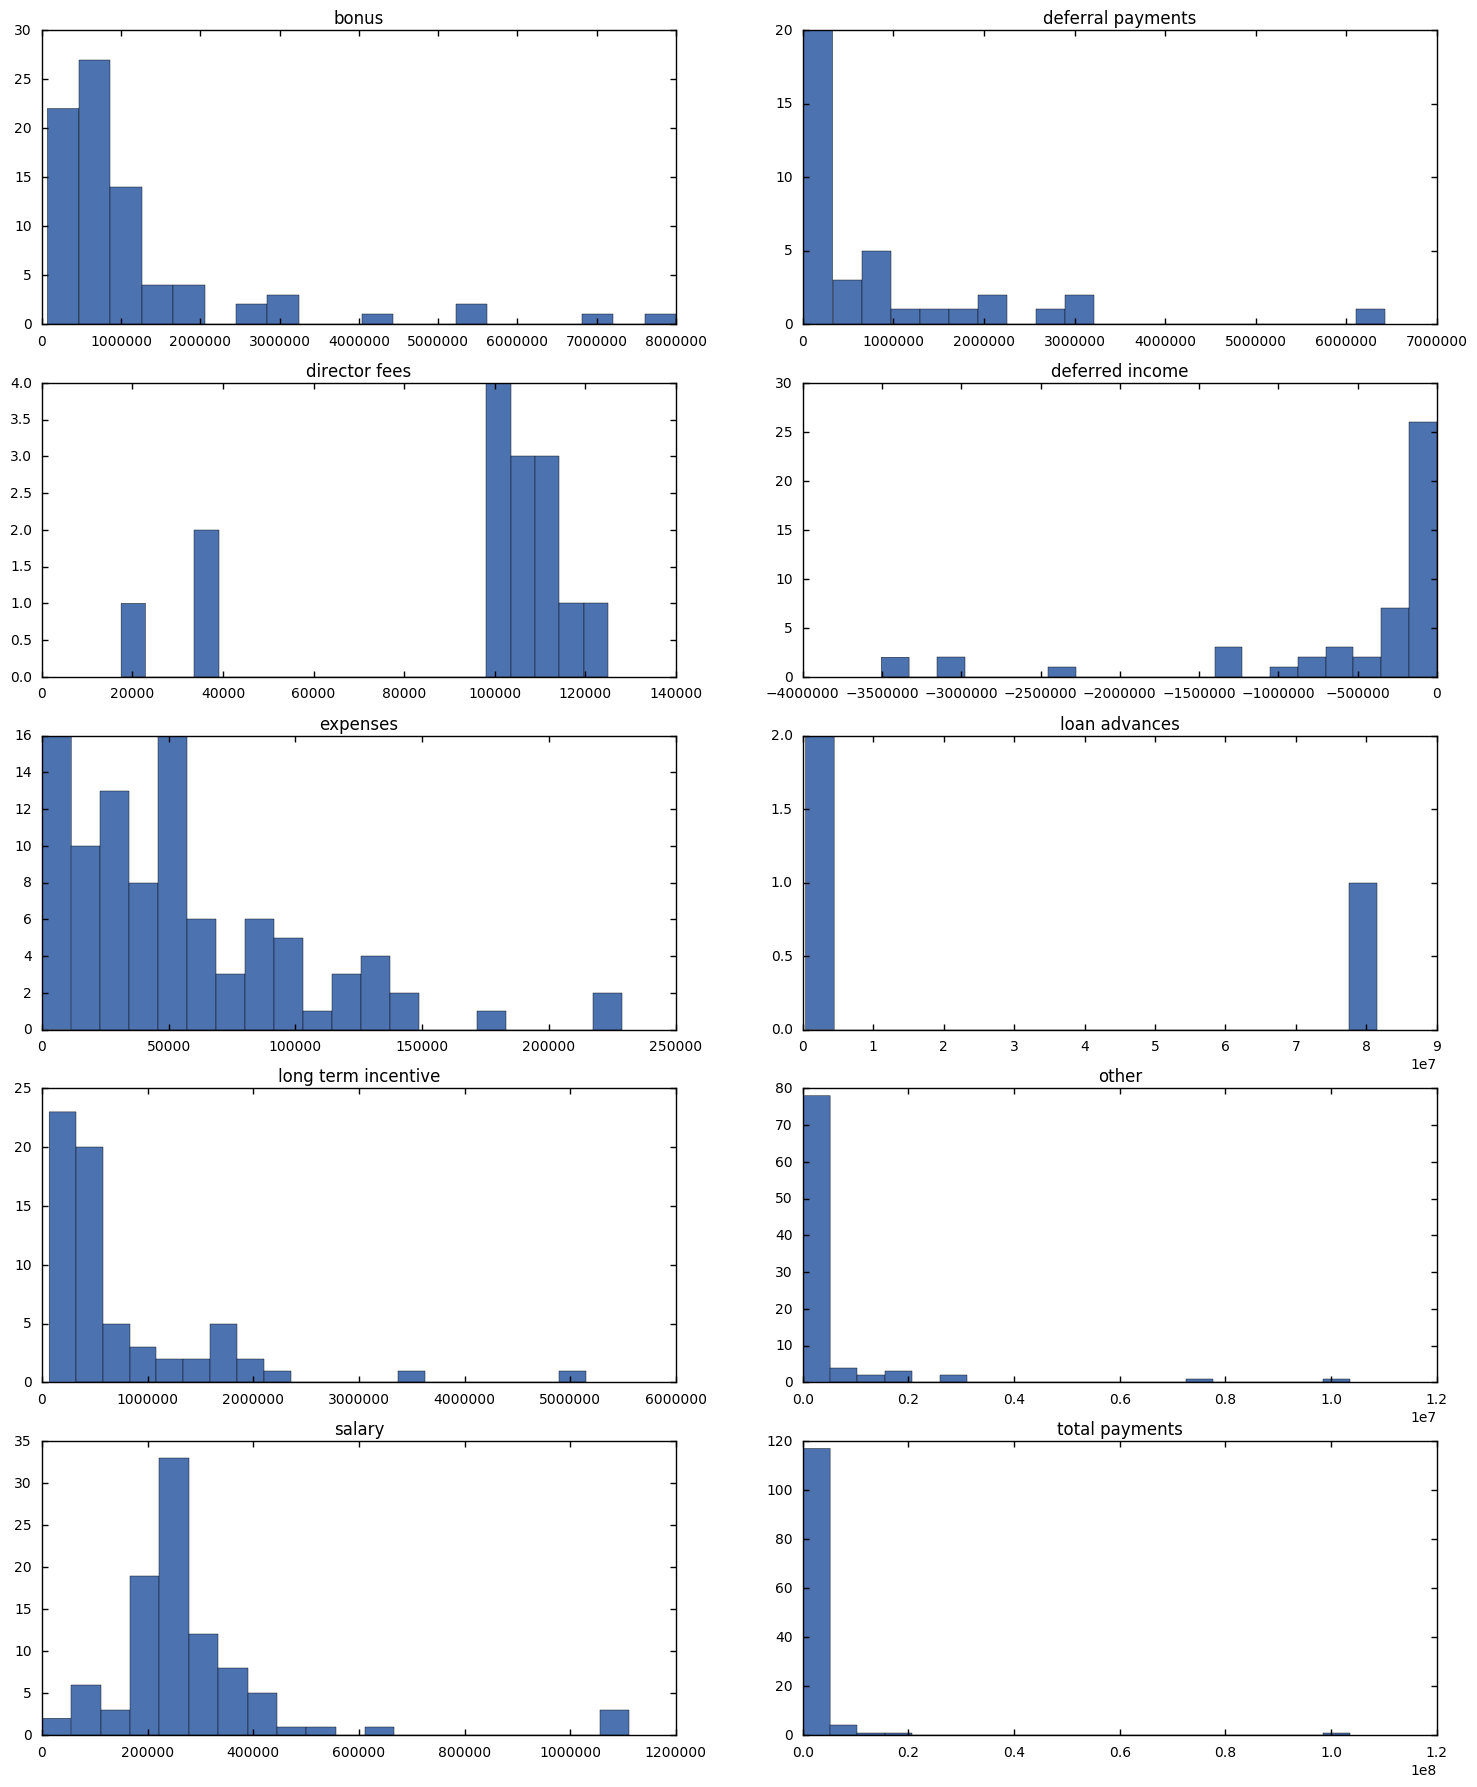

In [61]:
hide_code
# Plotting finance features
plt.style.use('seaborn-deep')

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 22))
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flat

ax0.hist(column_without_nan(enron_df['bonus']), 20)
ax0.set_title('bonus')
ax1.hist(column_without_nan(enron_df['deferral_payments']), 20)
ax1.set_title('deferral payments')
ax2.hist(column_without_nan(enron_df['director_fees']), 20)
ax2.set_title('director fees')
ax3.hist(column_without_nan(enron_df['deferred_income']), 20)
ax3.set_title('deferred income')
ax4.hist(column_without_nan(enron_df['expenses']), 20)
ax4.set_title('expenses')
ax5.hist(column_without_nan(enron_df['loan_advances']), 20)
ax5.set_title('loan advances')
ax6.hist(column_without_nan(enron_df['long_term_incentive']), 20)
ax6.set_title('long term incentive')
ax7.hist(column_without_nan(enron_df['other']), 20)
ax7.set_title('other')
ax8.hist(column_without_nan(enron_df['salary']), 20)
ax8.set_title('salary')
ax9.hist(column_without_nan(enron_df['total_payments']), 20)
ax9.set_title('total payments')

plt.show()

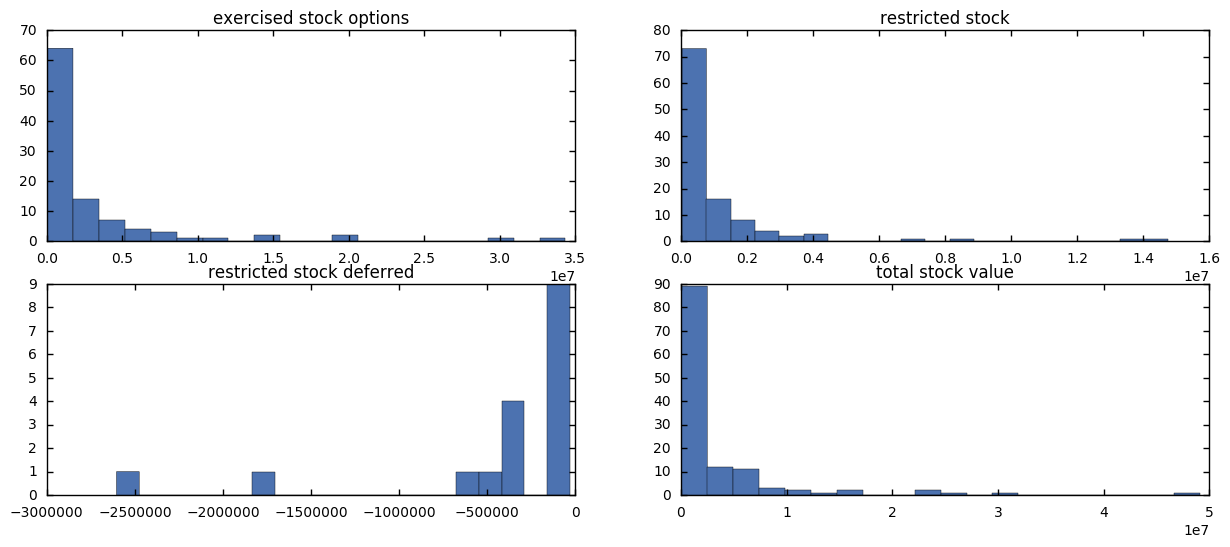

In [62]:
hide_code
# Plotting finance features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
ax0, ax1, ax2, ax3 = axes.flat

ax0.hist(column_without_nan(enron_df['exercised_stock_options']), 20)
ax0.set_title('exercised stock options')
ax1.hist(column_without_nan(enron_df['restricted_stock']), 20)
ax1.set_title('restricted stock')
ax2.hist(column_without_nan(enron_df['restricted_stock_deferred']), 20)
ax2.set_title('restricted stock deferred')
ax3.hist(column_without_nan(enron_df['total_stock_value']), 20)
ax3.set_title('total stock value')

plt.show()

##### 3.3.5 Email features without replacement of NaN values (statistical description and the histograms)

In [63]:
hide_code
# Create a list of email features
email_feature_list = ['to_messages', 'from_poi_to_this_person', 'from_messages', 
                      'from_this_person_to_poi', 'shared_receipt_with_poi']
# Display statistical decription for email features
for element in email_feature_list:
    print element, ":", scipy.stats.describe(column_without_nan(enron_df[element]))

to_messages : DescribeResult(nobs=86, minmax=(57, 15149), mean=2073.8604651162791, variance=6670344.3567715446, skewness=2.833035400609325, kurtosis=9.596670352428555)
from_poi_to_this_person : DescribeResult(nobs=86, minmax=(0, 528), mean=64.895348837209298, variance=7565.3889192886463, skewness=2.5258008078605707, kurtosis=8.454651111734721)
from_messages : DescribeResult(nobs=86, minmax=(12, 14368), mean=608.79069767441865, variance=3389406.0027359775, skewness=5.550524432566725, kurtosis=35.93246706516176)
from_this_person_to_poi : DescribeResult(nobs=86, minmax=(0, 609), mean=41.232558139534881, variance=10014.627633378934, skewness=3.8095632734172336, kurtosis=15.104575137265357)
shared_receipt_with_poi : DescribeResult(nobs=86, minmax=(2, 5521), mean=1176.4651162790697, variance=1388432.4634746921, skewness=1.3528055130045753, kurtosis=1.636267165088241)


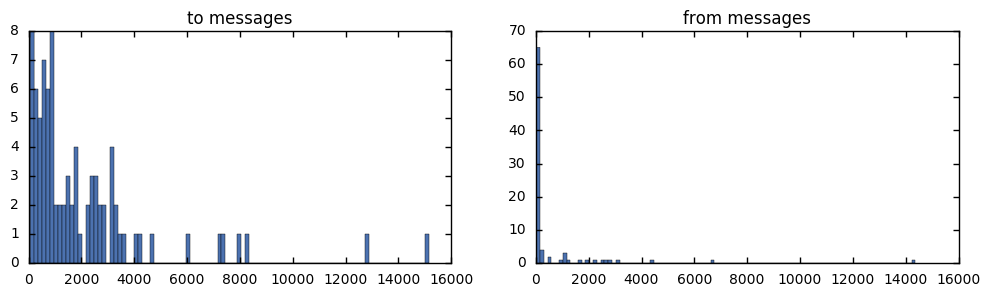

In [64]:
hide_code
# Plotting email features
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
ax0, ax1 = axes.flat

ax0.hist(column_without_nan(enron_df['to_messages']), 100)
ax0.set_title('to messages')
ax1.hist(column_without_nan(enron_df['from_messages']), 100)
ax1.set_title('from messages')

plt.show()

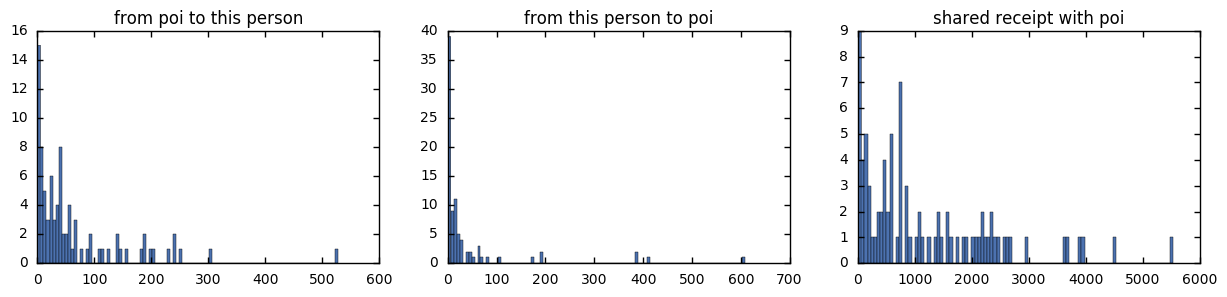

In [65]:
hide_code
# Plotting email features
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
ax0, ax1, ax2 = axes.flat

ax0.hist(column_without_nan(enron_df['from_poi_to_this_person']), 100)
ax0.set_title('from poi to this person')
ax1.hist(column_without_nan(enron_df['from_this_person_to_poi']), 100)
ax1.set_title('from this person to poi')
ax2.hist(column_without_nan(enron_df['shared_receipt_with_poi']), 100)
ax2.set_title('shared receipt with poi')

plt.show()

##### 3.3.6 Outliers in email features

Let us discover the influence of deleting outliers in the case of email features using as an example only one variable. 

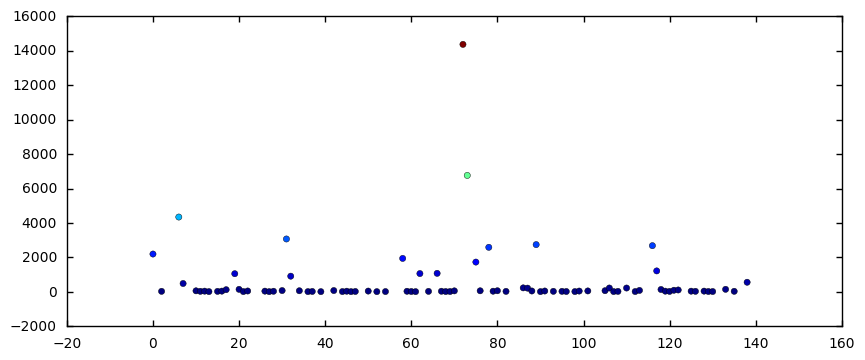

In [66]:
hide_code
# Plot 'from_messages'
plt.figure(figsize=(10,4))
x = list(enron_df['from_messages'][enron_df['from_messages'] != 'NaN'].index)
y = enron_df['from_messages'][enron_df['from_messages'] != 'NaN']
plt.scatter(x, y, c=y, cmap='jet')

In [67]:
hide_code
# Find the name of the outlier
print "Maximum values in each column."
print "from messages:", enron_df['staff_name'][enron_df['from_messages'].idxmax()]
print "to messages:", enron_df['staff_name'][enron_df['to_messages'].idxmax()]
print "from this person to poi:", enron_df['staff_name'][enron_df['from_this_person_to_poi'].idxmax()]
print "from poi to this person:", enron_df['staff_name'][enron_df['from_poi_to_this_person'].idxmax()]
print "shared receipt with poi:", enron_df['staff_name'][enron_df['shared_receipt_with_poi'].idxmax()]

Maximum values in each column.
from messages: KAMINSKI WINCENTY J
to messages: SHAPIRO RICHARD S
from this person to poi: DELAINEY DAVID W
from poi to this person: LAVORATO JOHN J
shared receipt with poi: BELDEN TIMOTHY N


In [68]:
hide_code
# Find 1 outlier for each email feature
email_outliers = enron_df[(enron_df['staff_name'] == 'KAMINSKI WINCENTY J') | 
                          (enron_df['staff_name'] == 'SHAPIRO RICHARD S') | 
                          (enron_df['staff_name'] == 'DELAINEY DAVID W') | 
                          (enron_df['staff_name'] == 'LAVORATO JOHN J') |
                          (enron_df['staff_name'] == 'BELDEN TIMOTHY N') ] \
[['staff_name', 'to_messages', 'from_messages', 
  'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']]

email_outliers_list = ['KAMINSKI WINCENTY J', 'SHAPIRO RICHARD S', 'DELAINEY DAVID W', 
                       'LAVORATO JOHN J', 'BELDEN TIMOTHY N']
email_outliers

,staff_name,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
7,BELDEN TIMOTHY N,7991,484,228,108,5521
31,DELAINEY DAVID W,3093,3069,66,609,2097
72,KAMINSKI WINCENTY J,4607,14368,41,171,583
78,LAVORATO JOHN J,7259,2585,528,411,3962
117,SHAPIRO RICHARD S,15149,1215,74,65,4527


Plot 'from_messages' without 1 outlier for 5 variables


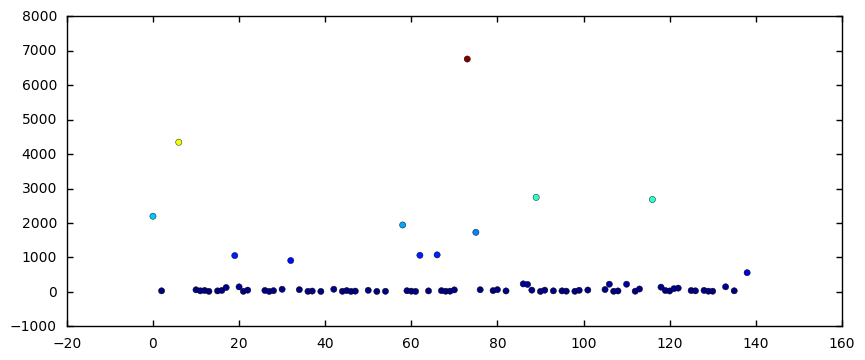

In [69]:
hide_code
print "Plot 'from_messages' without 1 outlier for 5 variables"
y_no_outliers = enron_df['from_messages']\
[(enron_df['staff_name'] != 'KAMINSKI WINCENTY J') & (enron_df['staff_name'] != 'SHAPIRO RICHARD S') &
(enron_df['staff_name'] != 'DELAINEY DAVID W') & (enron_df['staff_name'] != 'LAVORATO JOHN J') &
(enron_df['staff_name'] != 'BELDEN TIMOTHY N')]

plt.figure(figsize=(10,4))
x_no_outliers = list(y_no_outliers.index)
plt.scatter(x_no_outliers, y_no_outliers, c=y_no_outliers, cmap='jet')

In [70]:
hide_code
print "3 maximum values in each column."
print show_three_top(enron_df, 'from_messages')
print show_three_top(enron_df, 'to_messages')
print show_three_top(enron_df, 'from_this_person_to_poi')
print show_three_top(enron_df, 'from_poi_to_this_person')
print show_three_top(enron_df, 'shared_receipt_with_poi')

3 maximum values in each column.
three largest from_messages :
[14368, 6759, 4343]
three largest to_messages :
[15149, 12754, 8305]
three largest from_this_person_to_poi :
[609, 411, 387]
three largest from_poi_to_this_person :
[528, 305, 251]
three largest shared_receipt_with_poi :
[5521, 4527, 3962]


Plot 'from_messages' without 3 outlier for 1 variable


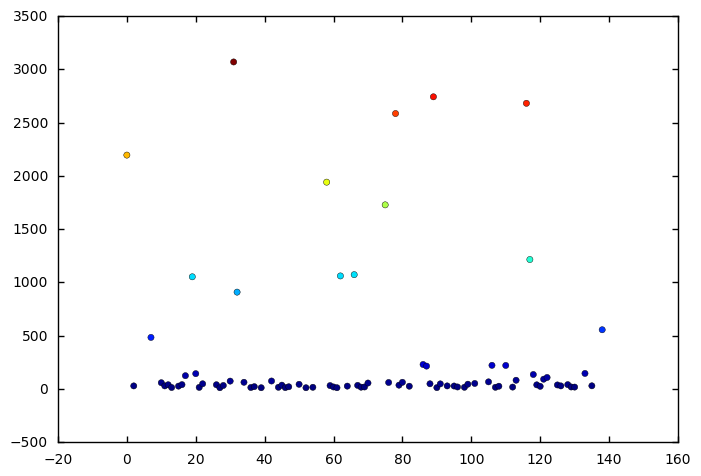

In [71]:
hide_code
print "Plot 'from_messages' without 3 outlier for 1 variable"
y3outliers = enron_df['from_messages'][(enron_df['from_messages'] < 4343) & (enron_df['from_messages'] != 'NaN')]
x3outliers = list(y3outliers.index)
plt.scatter(x3outliers, y3outliers, c=y3outliers, cmap='jet')

Removing rows with large values leads to the appearance of new outliers. I decided not to remove them in order to avoid the loss of valuable information.

##### 3.3.6 Replacement of NaN values by mean and scaling the features

In [72]:
hide_code
# Replace string NaN by np.nan
enron_df_np = enron_df.apply(column_with_npnan)

In [73]:
hide_code
# Setup Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=1)
# Setup Scaler
scaler = MinMaxScaler()

In [74]:
hide_code
# Setup feature list without email address
feature_list0 = ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'expenses', 
                'exercised_stock_options', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 
                'restricted_stock_deferred', 'salary', 'total_payments', 'total_stock_value',
                'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 
                 'shared_receipt_with_poi']

In [75]:
hide_code
# Setup variable for features after Imputer and Scaler
feature_imp = [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], 
                      [0], [0], [0], [0], [0], [0], [0], [0], [0]]
feature_imp_scaled = [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], 
                      [0], [0], [0], [0], [0], [0], [0], [0], [0]]

In [76]:
hide_code
# Transform data for finance features by Imputer
for i in range(len(feature_list0)):
    element = feature_list0[i]
    imp.fit([enron_df_np[element]])
    feature_imp[i] = imp.transform([enron_df_np[element]])
    feature_imp[i] = feature_imp[i][0]
    feature_imp_scaled[i] = scaler.fit_transform(feature_imp[i])

enron_df_imp_scaled = pd.DataFrame(feature_imp_scaled)
enron_df_imp_scaled.index = feature_list0

In [77]:
hide_code
#Transform the dataframe
enron_df_imp_scaled = enron_df_imp_scaled.T

In [78]:
enron_df_imp_scaled.head().T

,0,1,2,3,4
bonus,0.517654,0.142720,0.142720,0.142497,0.041614
deferral_payments,0.445824,0.026643,0.133845,0.200619,0.039335
deferred_income,0.120829,0.837179,0.998781,0.604624,0.942684
director_fees,0.704284,0.704284,0.704284,0.704284,0.704284
expenses,0.060014,0.014601,0.245623,0.048343,0.564241
exercised_stock_options,0.050082,0.007223,0.117546,0.194264,0.090506
loan_advances,0.339908,0.339908,0.339908,0.339908,0.339908
long_term_incentive,0.046409,0.133420,0.133420,0.298812,0.133420
other,0.000014,0.045259,0.083450,0.256793,0.000006
restricted_stock,0.006352,0.078231,0.117120,0.265476,0.007695


##### 3.3.7 Finance features with replacement of NaN values by mean and rescaling

The histograms of all finance features after these processes we can see below.

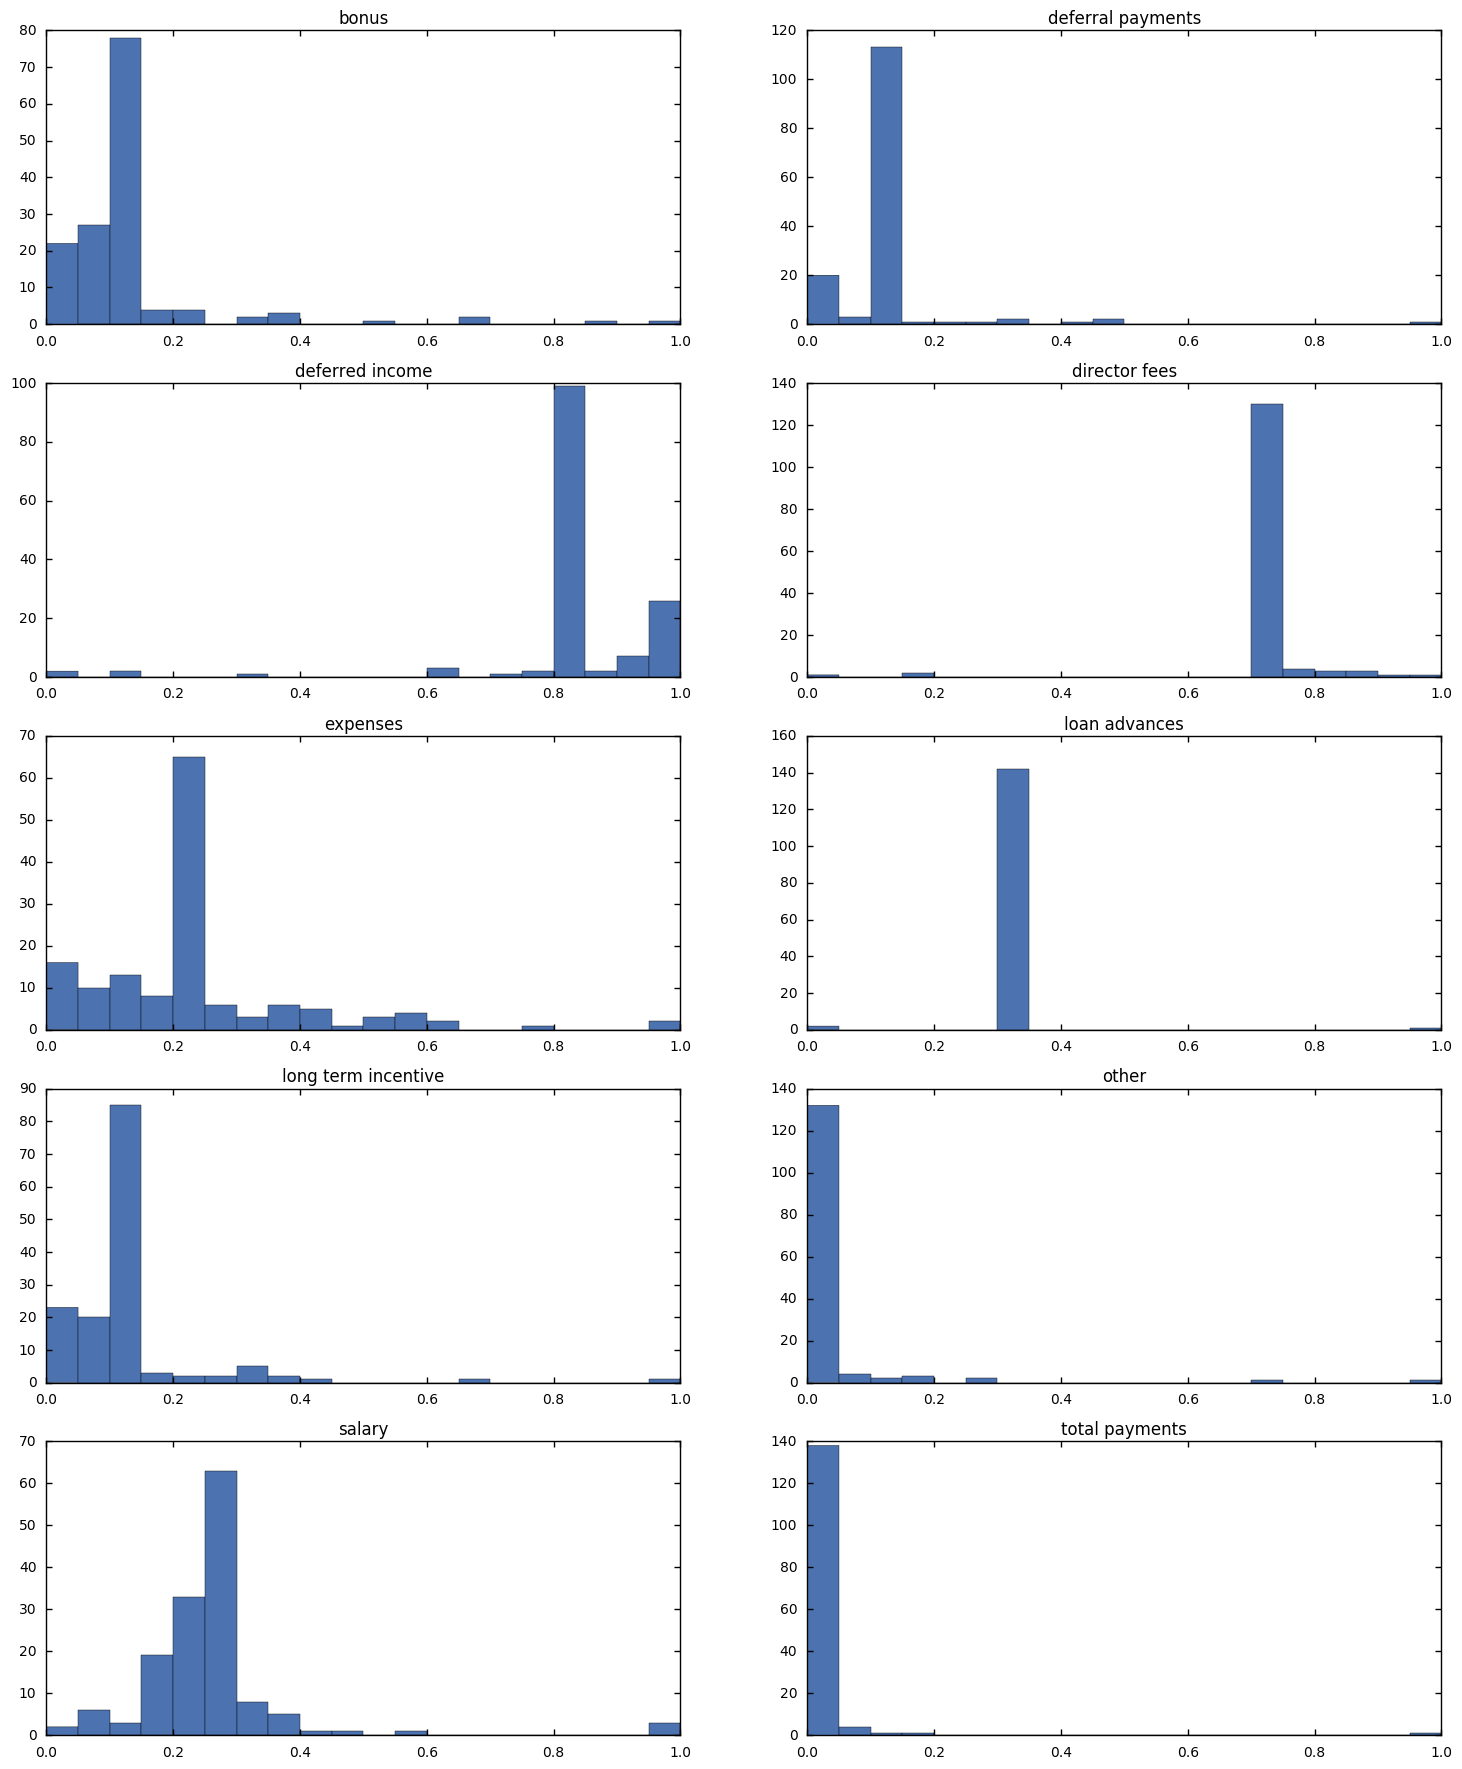

In [79]:
hide_code
# Plotting finance features
plt.style.use('seaborn-deep')

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 22))
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flat

ax0.hist(enron_df_imp_scaled['bonus'], 20)
ax0.set_title('bonus')
ax1.hist(enron_df_imp_scaled['deferral_payments'], 20)
ax1.set_title('deferral payments')
ax2.hist(enron_df_imp_scaled['deferred_income'], 20)
ax2.set_title('deferred income')
ax3.hist(enron_df_imp_scaled['director_fees'], 20)
ax3.set_title('director fees')
ax4.hist(enron_df_imp_scaled['expenses'], 20)
ax4.set_title('expenses')
ax5.hist(enron_df_imp_scaled['loan_advances'], 20)
ax5.set_title('loan advances')
ax6.hist(enron_df_imp_scaled['long_term_incentive'], 20)
ax6.set_title('long term incentive')
ax7.hist(enron_df_imp_scaled['other'], 20)
ax7.set_title('other')
ax8.hist(enron_df_imp_scaled['salary'], 20)
ax8.set_title('salary')
ax9.hist(enron_df_imp_scaled['total_payments'], 20)
ax9.set_title('total payments')

plt.show()

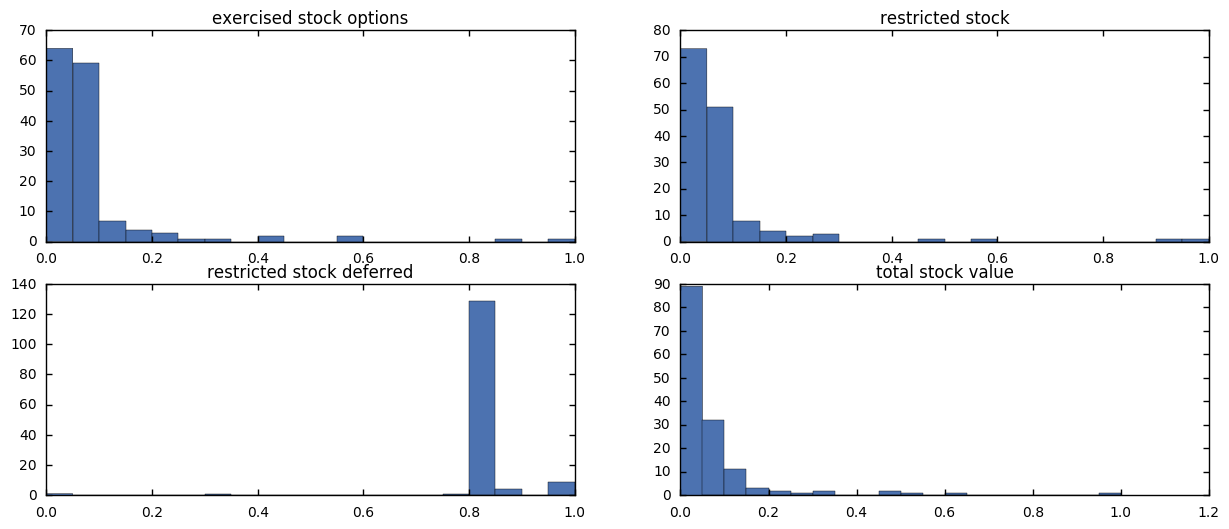

In [80]:
hide_code
# Plotting finance features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
ax0, ax1, ax2, ax3 = axes.flat

ax0.hist(enron_df_imp_scaled['exercised_stock_options'], 20)
ax0.set_title('exercised stock options')
ax1.hist(enron_df_imp_scaled['restricted_stock'], 20)
ax1.set_title('restricted stock')
ax2.hist(enron_df_imp_scaled['restricted_stock_deferred'], 20)
ax2.set_title('restricted stock deferred')
ax3.hist(enron_df_imp_scaled['total_stock_value'], 20)
ax3.set_title('total stock value')

plt.show()

##### 3.3.8 Email features with replacement of NaN values by mean and rescaling

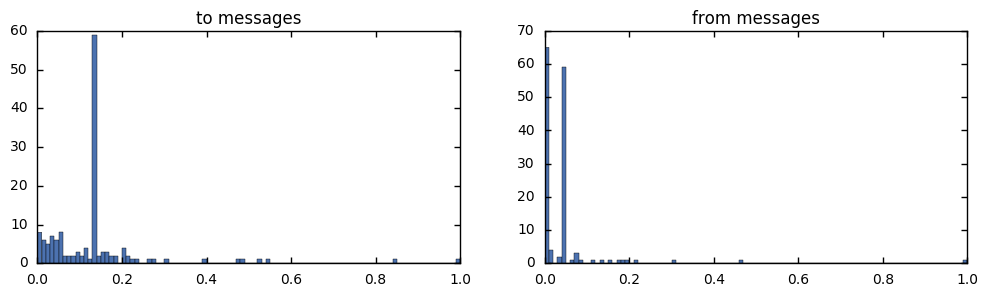

In [81]:
hide_code
# Plotting email features
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
ax0, ax1 = axes.flat

ax0.hist(enron_df_imp_scaled['to_messages'], 100)
ax0.set_title('to messages')
ax1.hist(enron_df_imp_scaled['from_messages'], 100)
ax1.set_title('from messages')

plt.show()

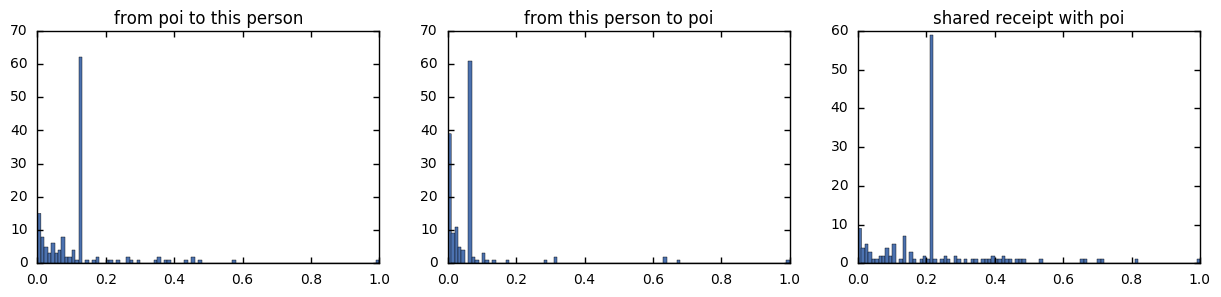

In [82]:
hide_code
# Plotting email features
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
ax0, ax1, ax2 = axes.flat

ax0.hist(enron_df_imp_scaled['from_poi_to_this_person'], 100)
ax0.set_title('from poi to this person')
ax1.hist(enron_df_imp_scaled['from_this_person_to_poi'], 100)
ax1.set_title('from this person to poi')
ax2.hist(enron_df_imp_scaled['shared_receipt_with_poi'], 100)
ax2.set_title('shared receipt with poi')

plt.show()

##### 3.3.9 A dataframe and a dictionary with replacement of NaN values by mean and rescaling

In [83]:
hide_code
# Complete a scaled dataframe
df1 = enron_df['staff_name']
df2 = enron_df['email_address']
df3 = enron_df['poi']
scaled_enron_df = pd.concat([enron_df_imp_scaled, df1, df2, df3], axis=1)
scaled_enron_df.head().T

,0,1,2,3,4
bonus,0.517654,0.14272,0.14272,0.142497,0.0416141
deferral_payments,0.445824,0.0266425,0.133845,0.200619,0.0393352
deferred_income,0.120829,0.837179,0.998781,0.604624,0.942684
director_fees,0.704284,0.704284,0.704284,0.704284,0.704284
expenses,0.0600136,0.014601,0.245623,0.0483433,0.564241
exercised_stock_options,0.0500818,0.0072226,0.117546,0.194264,0.0905057
loan_advances,0.339908,0.339908,0.339908,0.339908,0.339908
long_term_incentive,0.046409,0.13342,0.13342,0.298812,0.13342
other,1.44791e-05,0.0452592,0.0834502,0.256793,6.46735e-06
restricted_stock,0.00635247,0.0782314,0.11712,0.265476,0.00769463


In [84]:
scaled_enron_data = scaled_enron_df.to_dict(orient="index")

In [85]:
hide_code
print "The example of features in the dictionary: ", str(scaled_enron_data.itervalues().next())

The example of features in the dictionary:  {'to_messages': 0.188510469122714, 'staff_name': 'ALLEN PHILLIP K', 'deferral_payments': 0.4458238154088415, 'expenses': 0.06001355991514118, 'poi': False, 'long_term_incentive': 0.046409024368766386, 'email_address': 'phillip.allen@enron.com', 'from_poi_to_this_person': 0.08901515151515152, 'deferred_income': 0.12082905553305456, 'restricted_stock_deferred': 0.9636213418972563, 'shared_receipt_with_poi': 0.2545751041855408, 'loan_advances': 0.3399075500770416, 'from_messages': 0.1520618556701031, 'other': 1.4479146023828618e-05, 'director_fees': 0.7042839164047339, 'bonus': 0.5176544766708702, 'total_stock_value': 0.034651561654463786, 'from_this_person_to_poi': 0.10673234811165845, 'restricted_stock': 0.006352468838501718, 'salary': 0.18138408921290516, 'total_payments': 0.04330155824694069, 'exercised_stock_options': 0.05008180157473601}


##### 3.3.10 Dataframes for correlation plotting

In [86]:
hide_code
correlation_enron_df = pd.DataFrame(scaled_enron_df)

In [87]:
hide_code
correlation_enron_ff = correlation_enron_df.drop(correlation_enron_df[['staff_name', 'email_address', 'poi', 
                                                                       'to_messages', 'from_poi_to_this_person',
                                                                       'from_messages', 'from_this_person_to_poi',
                                                                       'shared_receipt_with_poi']], axis=1)
print "correlation_enron_ff:", list(correlation_enron_ff.T.index)

correlation_enron_ff: ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'expenses', 'exercised_stock_options', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'total_payments', 'total_stock_value']


In [88]:
correlation_enron_ef = correlation_enron_df[['to_messages', 'from_poi_to_this_person',
                                            'from_messages', 'from_this_person_to_poi',
                                            'shared_receipt_with_poi']]
print "correlation_enron_ef:", list(correlation_enron_ef.T.index)

correlation_enron_ef: ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


### 3.4 CSV file

In [89]:
enron_df.to_csv('enron.csv')

In [90]:
scaled_enron_df.to_csv('scaled_enron.csv')

In [91]:
correlation_enron_ff.to_csv('correlation_enron_ff.csv')

In [92]:
correlation_enron_ef.to_csv('correlation_enron_ef.csv')

### 3.5 Feature selection

##### 3.5.1 Correlation

A graphical display of a correlation matrix, highlighting the most correlated variables in a data table, help us understand relationship between features.

Financial features:

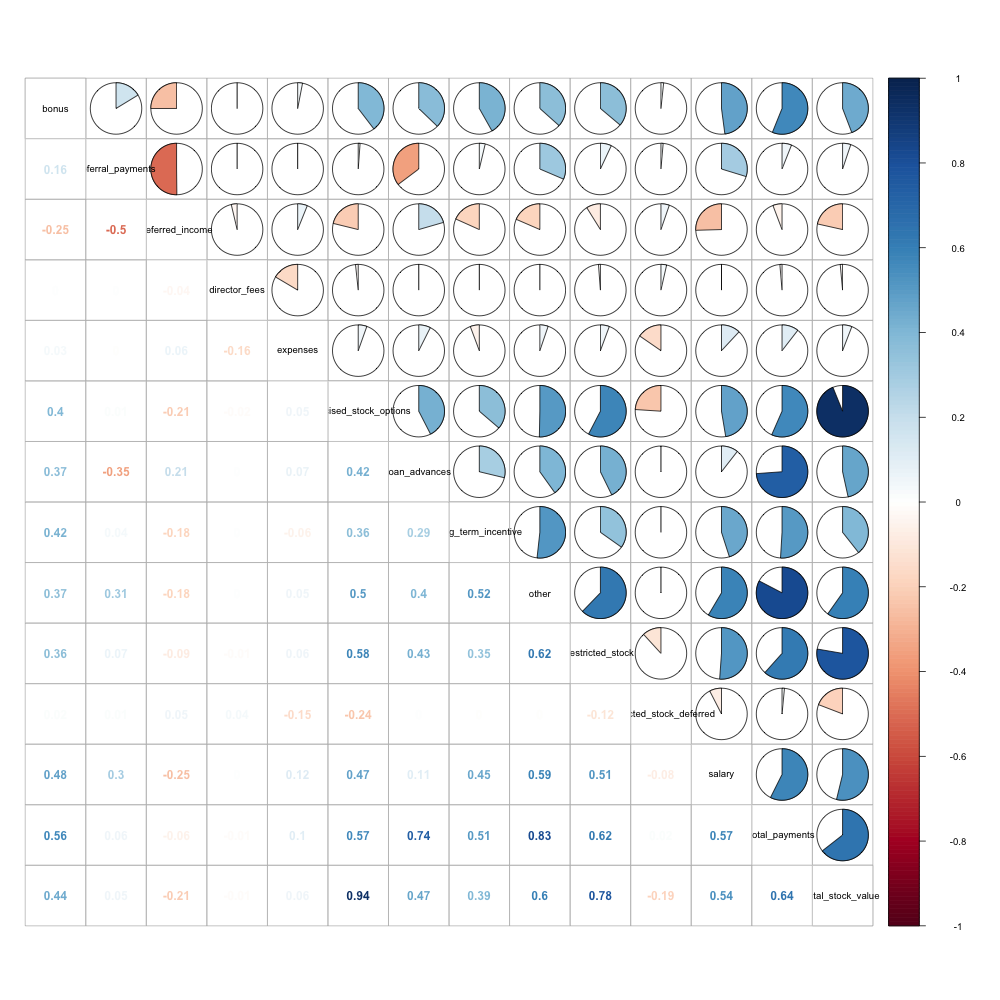

In [93]:
%%R -w1000 -h1000
correlation_enron_ff <- read.csv("correlation_enron_ff.csv")
correlation_enron_ff$X <- NULL
plot <- corrplot.mixed(cor(correlation_enron_ff), lower="number", upper="pie", 
                       order ="original", tl.col="black", tl.cex=0.8)

Email features:

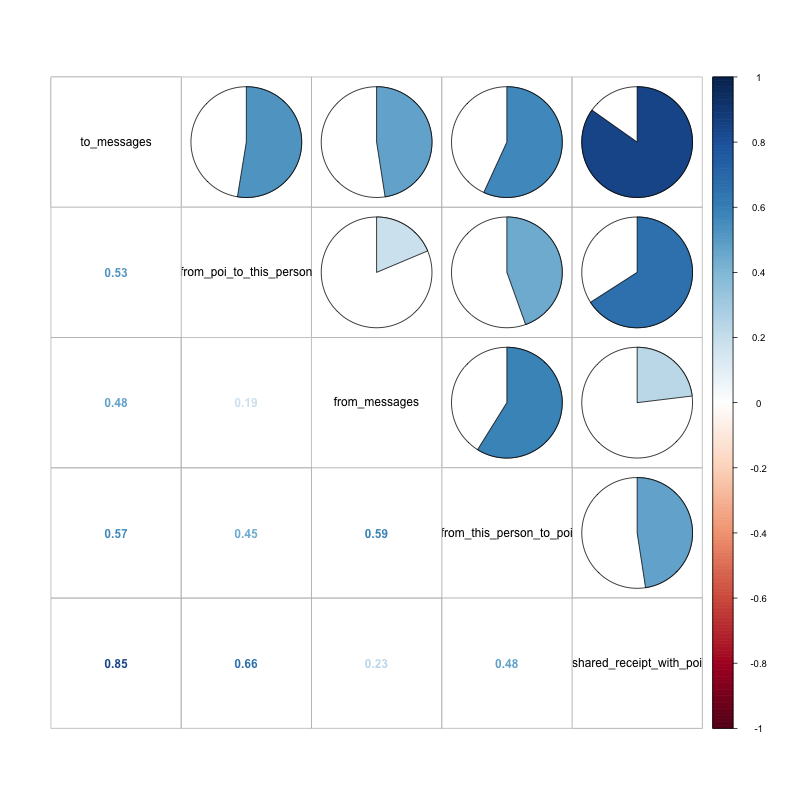

In [94]:
%%R -w800 -h800
correlation_enron_ef <- read.csv("correlation_enron_ef.csv")
correlation_enron_ef$X <- NULL
plot2 <- corrplot.mixed(cor(correlation_enron_ef), lower="number", upper="pie", 
                       order ="original", tl.col="black", tl.cex=1.0)

A very small number of strong dependencies between variables is observed. It means we should use a lot of features for building a model or construct some new.

##### 3.5.2 Polyfit

We always think of models as simplified theoretical approximations of the reality. As such there is some inferiority involved, also called the approximation error. Before fitting the complex models we can try to research dependencies between variables as a part of understanding our dataset.

In [95]:
hide_code
# Setup features for polyfitting
x1 = scaled_enron_df['salary']
y1 = scaled_enron_df['bonus']

In [96]:
hide_code
# Polyfit for 1 degree
fp11, residuals11, rank11, sv11, rcond11 = scipy.polyfit(x1, y1, 1, full=True)
print ("Model parameters for salary and bonus (1 degree): %s" %  fp11)


Model parameters for salary and bonus (1 degree): [ 0.50652335  0.01339219]


The formulae of the polyfit line (1 degree): f(x) = 3.61613148 * x + 174475.168

In [97]:
hide_code
# Polyfit for 3,5,7 degree
fp12 = scipy.polyfit(x1, y1, 3)
fp13 = scipy.polyfit(x1, y1, 5)
fp14 = scipy.polyfit(x1, y1, 7)

In [98]:
hide_code
# Create lines with coefficients
f11 = scipy.poly1d(fp11)
f12 = scipy.poly1d(fp12)
f13 = scipy.poly1d(fp13)
f14 = scipy.poly1d(fp14)

Polyfit for 1, 3, 5, 7 degrees for salary and bonus.


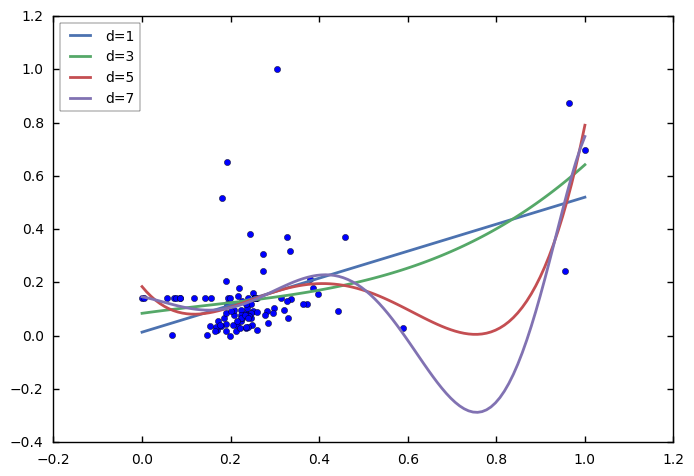

In [99]:
hide_code
print "Polyfit for 1, 3, 5, 7 degrees for salary and bonus."
fx1 = scipy.linspace(0, 1.0, 100) 
plt.plot(fx1, f11(fx1), linewidth=2)
plt.plot(fx1, f12(fx1), linewidth=2)
plt.plot(fx1, f13(fx1), linewidth=2)
plt.plot(fx1, f14(fx1), linewidth=2)
plt.scatter(x1, y1)
plt.legend(["d=%i" % f11.order, "d=%i" % f12.order, "d=%i" % f13.order, "d=%i" % f14.order], loc="upper left")

In [100]:
hide_code
# Setup features for polyfitting
x2 = scaled_enron_df['from_this_person_to_poi']
y2 = scaled_enron_df['from_messages']

In [101]:
hide_code
# Polyfit for 1 degree
fp21, residuals21, rank21, sv21, rcond21 = scipy.polyfit(x2, y2, 1, full=True)
print ("Model parameters for from_this_person_to_poi and from_messages (1 dergee): %s" %  fp21)

Model parameters for from_this_person_to_poi and from_messages (1 dergee): [ 0.45942283  0.01046544]


In [102]:
hide_code
# Polyfit for 1, 3, 5 degree
fp22 = scipy.polyfit(x2, y2, 3)
fp23 = scipy.polyfit(x2, y2, 5)

In [103]:
hide_code
# Polyfit for 1, 3, 5 degree
f21 = scipy.poly1d(fp21)
f22 = scipy.poly1d(fp22)
f23 = scipy.poly1d(fp23)

Polyfit for 1, 3, 5 degrees for from_this_person_to_poi and from_poi_to_this_person.


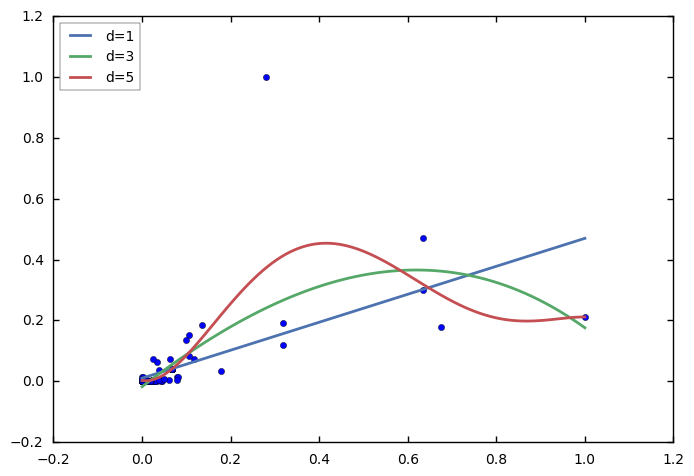

In [104]:
hide_code
print "Polyfit for 1, 3, 5 degrees for from_this_person_to_poi and from_poi_to_this_person."
fx2 = scipy.linspace(0, 1, 100) 
plt.plot(fx2, f21(fx2), linewidth=2)
plt.plot(fx2, f22(fx2), linewidth=2)
plt.plot(fx2, f23(fx2), linewidth=2)
plt.scatter(x2, y2)
plt.legend(["d=%i" % f21.order, "d=%i" % f22.order, "d=%i" % f23.order], loc="upper left")

In these pairs of variables I expected the presence of more stringent dependence.

##### 3.5.3 Experiments without creating new features

Feature sets:

In [112]:
features_list01 = ['poi','salary', 'bonus', 'exercised_stock_options', 'deferred_income']
features_list02 = ['poi','salary', 'bonus', 'exercised_stock_options', 'deferred_income', 
                   'expenses', 'long_term_incentive', 'restricted_stock']
features_list03 = ['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 
                   'long_term_incentive', 'expenses']
features_list04 = ['poi','from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
features_list05 = ['poi','salary', 'bonus', 'exercised_stock_options', 'deferred_income', 
                  'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']

Setup the dataset:

In [113]:
my_dataset = enron_data

Classifiers:

I wanted to perform a large number of tests, so I chose a fairly wide range of classifiers.

In [115]:
clf01 =  DecisionTreeClassifier(max_depth=1)
clf02 =  AdaBoostClassifier()
clf03 =  RandomForestClassifier(min_samples_split=50)
clf04 =  GaussianNB()
clf05 =  neighbors.KNeighborsClassifier()
clf06 =  QuadraticDiscriminantAnalysis()
clf07 =  KMeans(n_clusters=2)
clf08 =  LogisticRegression()

Results:

For each set of features results are arranged in ascending order of accuracy.

In [116]:
hide_code
data01 = featureFormat(my_dataset, features_list01, sort_keys = True)
labels01, features01 = targetFeatureSplit(data01)

In [117]:
hide_code
features_train01, features_test01, labels_train01, labels_test01 = \
    train_test_split(features01, labels01, test_size=0.3, random_state=42)

In [118]:
hide_code
dump_classifier_and_data(clf02, my_dataset, features_list01)
load_classifier_and_data()
print features_list01

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income']


In [119]:
hide_code
if __name__ == '__main__':
    main()

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.81300	Precision: 0.31972	Recall: 0.27400	F1: 0.29510	F2: 0.28207
	Total predictions: 14000	True positives:  548	False positives: 1166	False negatives: 1452	True negatives: 10834



In [120]:
hide_code
dump_classifier_and_data(clf01, my_dataset, features_list01)
load_classifier_and_data()
print features_list01

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income']


In [121]:
hide_code
if __name__ == '__main__':
    main()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.85007	Precision: 0.37405	Recall: 0.07350	F1: 0.12286	F2: 0.08757
	Total predictions: 14000	True positives:  147	False positives:  246	False negatives: 1853	True negatives: 11754



In [122]:
hide_code
dump_classifier_and_data(clf06, my_dataset, features_list01)
load_classifier_and_data()
print features_list01

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income']


In [123]:
hide_code
if __name__ == '__main__':
    main()

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)
	Accuracy: 0.85614	Precision: 0.49413	Recall: 0.29450	F1: 0.36905	F2: 0.32039
	Total predictions: 14000	True positives:  589	False positives:  603	False negatives: 1411	True negatives: 11397



In [124]:
hide_code
dump_classifier_and_data(clf03, my_dataset, features_list01)
load_classifier_and_data()
print features_list01

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income']


In [125]:
hide_code
if __name__ == '__main__':
    main()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.85814	Precision: 0.51199	Recall: 0.14950	F1: 0.23142	F2: 0.17416
	Total predictions: 14000	True positives:  299	False positives:  285	False negatives: 1701	True negatives: 11715



In [126]:
hide_code
dump_classifier_and_data(clf04, my_dataset, features_list01)
load_classifier_and_data()
print features_list01

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income']


In [127]:
hide_code
if __name__ == '__main__':
    main()

GaussianNB(priors=None)
	Accuracy: 0.86043	Precision: 0.51662	Recall: 0.35750	F1: 0.42258	F2: 0.38097
	Total predictions: 14000	True positives:  715	False positives:  669	False negatives: 1285	True negatives: 11331



In [128]:
hide_code
dump_classifier_and_data(clf05, my_dataset, features_list01)
load_classifier_and_data()
print features_list01

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income']


In [129]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
	Accuracy: 0.88879	Precision: 0.78361	Recall: 0.30600	F1: 0.44013	F2: 0.34848
	Total predictions: 14000	True positives:  612	False positives:  169	False negatives: 1388	True negatives: 11831



In [130]:
hide_code
data02 = featureFormat(my_dataset, features_list02, sort_keys = True)
labels02, features02 = targetFeatureSplit(data02)

In [131]:
hide_code
features_train02, features_test02, labels_train02, labels_test02 = \
    train_test_split(features02, labels02, test_size=0.3, random_state=42)

In [132]:
hide_code
dump_classifier_and_data(clf04, my_dataset, features_list02)
load_classifier_and_data()
print features_list02

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'expenses', 'long_term_incentive', 'restricted_stock']


In [133]:
hide_code
if __name__ == '__main__':
    main()

GaussianNB(priors=None)
	Accuracy: 0.85007	Precision: 0.43237	Recall: 0.39800	F1: 0.41448	F2: 0.40443
	Total predictions: 15000	True positives:  796	False positives: 1045	False negatives: 1204	True negatives: 11955



In [134]:
hide_code
dump_classifier_and_data(clf01, my_dataset, features_list02)
load_classifier_and_data()
print features_list02

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'expenses', 'long_term_incentive', 'restricted_stock']


In [135]:
hide_code
if __name__ == '__main__':
    main()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.85440	Precision: 0.33026	Recall: 0.08950	F1: 0.14083	F2: 0.10478
	Total predictions: 15000	True positives:  179	False positives:  363	False negatives: 1821	True negatives: 12637



In [136]:
hide_code
dump_classifier_and_data(clf02, my_dataset, features_list02)
load_classifier_and_data()
print features_list02

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'expenses', 'long_term_incentive', 'restricted_stock']


In [137]:
hide_code
if __name__ == '__main__':
    main()

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.86267	Precision: 0.47881	Recall: 0.33900	F1: 0.39696	F2: 0.36003
	Total predictions: 15000	True positives:  678	False positives:  738	False negatives: 1322	True negatives: 12262



In [138]:
hide_code
dump_classifier_and_data(clf05, my_dataset, features_list02)
load_classifier_and_data()
print features_list02

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'expenses', 'long_term_incentive', 'restricted_stock']


In [139]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
	Accuracy: 0.87387	Precision: 0.64917	Recall: 0.11750	F1: 0.19898	F2: 0.14052
	Total predictions: 15000	True positives:  235	False positives:  127	False negatives: 1765	True negatives: 12873



In [142]:
hide_code
data03 = featureFormat(my_dataset, features_list03, sort_keys = True)
labels03, features03 = targetFeatureSplit(data03)

In [143]:
hide_code
features_train03, features_test03, labels_train03, labels_test03 = \
    train_test_split(features03, labels03, test_size=0.3, random_state=42)

In [144]:
hide_code
dump_classifier_and_data(clf07, my_dataset, features_list03)
load_classifier_and_data()
print features_list03

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'long_term_incentive', 'expenses']


In [145]:
hide_code
if __name__ == '__main__':
    main()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
	Accuracy: 0.77086	Precision: 0.25347	Recall: 0.31050	F1: 0.27910	F2: 0.29713
	Total predictions: 14000	True positives:  621	False positives: 1829	False negatives: 1379	True negatives: 10171



In [146]:
hide_code
dump_classifier_and_data(clf01, my_dataset, features_list03)
load_classifier_and_data()
print features_list03

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'long_term_incentive', 'expenses']


In [147]:
hide_code
if __name__ == '__main__':
    main()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.84229	Precision: 0.30077	Recall: 0.07850	F1: 0.12450	F2: 0.09211
	Total predictions: 14000	True positives:  157	False positives:  365	False negatives: 1843	True negatives: 11635



In [148]:
hide_code
dump_classifier_and_data(clf06, my_dataset, features_list03)
load_classifier_and_data()
print features_list03

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'long_term_incentive', 'expenses']


In [149]:
hide_code
if __name__ == '__main__':
    main()

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)
	Accuracy: 0.84779	Precision: 0.44863	Recall: 0.28600	F1: 0.34931	F2: 0.30836
	Total predictions: 14000	True positives:  572	False positives:  703	False negatives: 1428	True negatives: 11297



In [150]:
hide_code
dump_classifier_and_data(clf04, my_dataset, features_list03)
load_classifier_and_data()
print features_list03

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'long_term_incentive', 'expenses']


In [151]:
hide_code
if __name__ == '__main__':
    main()

GaussianNB(priors=None)
	Accuracy: 0.85207	Precision: 0.47807	Recall: 0.38700	F1: 0.42774	F2: 0.40233
	Total predictions: 14000	True positives:  774	False positives:  845	False negatives: 1226	True negatives: 11155



In [152]:
hide_code
dump_classifier_and_data(clf03, my_dataset, features_list03)
load_classifier_and_data()
print features_list03

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'long_term_incentive', 'expenses']


In [153]:
hide_code
if __name__ == '__main__':
    main()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.85864	Precision: 0.52645	Recall: 0.10450	F1: 0.17438	F2: 0.12445
	Total predictions: 14000	True positives:  209	False positives:  188	False negatives: 1791	True negatives: 11812



In [154]:
hide_code
dump_classifier_and_data(clf02, my_dataset, features_list03)
load_classifier_and_data()
print features_list03

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'long_term_incentive', 'expenses']


In [155]:
hide_code
if __name__ == '__main__':
    main()

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.86300	Precision: 0.52863	Recall: 0.37850	F1: 0.44114	F2: 0.40129
	Total predictions: 14000	True positives:  757	False positives:  675	False negatives: 1243	True negatives: 11325



In [156]:
hide_code
dump_classifier_and_data(clf05, my_dataset, features_list03)
load_classifier_and_data()
print features_list03

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'long_term_incentive', 'expenses']


In [157]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
	Accuracy: 0.86629	Precision: 0.58696	Recall: 0.21600	F1: 0.31579	F2: 0.24725
	Total predictions: 14000	True positives:  432	False positives:  304	False negatives: 1568	True negatives: 11696



In [158]:
hide_code
data04 = featureFormat(my_dataset, features_list04, sort_keys = True)
labels04, features04 = targetFeatureSplit(data04)

In [159]:
hide_code
features_train04, features_test04, labels_train04, labels_test04 = \
    train_test_split(features04, labels04, test_size=0.3, random_state=42)

In [160]:
hide_code
dump_classifier_and_data(clf07, my_dataset, features_list04)
load_classifier_and_data()
print features_list04

['poi', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [161]:
hide_code
if __name__ == '__main__':
    main()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
	Accuracy: 0.74878	Precision: 0.11152	Recall: 0.18100	F1: 0.13801	F2: 0.16095
	Total predictions: 9000	True positives:  181	False positives: 1442	False negatives:  819	True negatives: 6558



In [162]:
hide_code
dump_classifier_and_data(clf02, my_dataset, features_list04)
load_classifier_and_data()
print features_list04

['poi', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [163]:
hide_code
if __name__ == '__main__':
    main()

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.80411	Precision: 0.17860	Recall: 0.21200	F1: 0.19387	F2: 0.20436
	Total predictions: 9000	True positives:  212	False positives:  975	False negatives:  788	True negatives: 7025



In [164]:
hide_code
dump_classifier_and_data(clf05, my_dataset, features_list04)
load_classifier_and_data()
print features_list04

['poi', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [165]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
	Accuracy: 0.80644	Precision: 0.14667	Recall: 0.15400	F1: 0.15024	F2: 0.15248
	Total predictions: 9000	True positives:  154	False positives:  896	False negatives:  846	True negatives: 7104



In [166]:
hide_code
dump_classifier_and_data(clf08, my_dataset, features_list04)
load_classifier_and_data()
print features_list04

['poi', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [167]:
hide_code
if __name__ == '__main__':
    main()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
	Accuracy: 0.87211	Precision: 0.35674	Recall: 0.18800	F1: 0.24623	F2: 0.20764
	Total predictions: 9000	True positives:  188	False positives:  339	False negatives:  812	True negatives: 7661



In [294]:
hide_code
data05 = featureFormat(my_dataset, features_list05, sort_keys = True)
labels05, features05 = targetFeatureSplit(data05)

In [295]:
hide_code
features_train05, features_test05, labels_train05, labels_test05 = \
    train_test_split(features05, labels05, test_size=0.3, random_state=42)

In [170]:
hide_code
dump_classifier_and_data(clf02, my_dataset, features_list05)
load_classifier_and_data()
print features_list05

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [171]:
hide_code
if __name__ == '__main__':
    main()

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.82000	Precision: 0.33811	Recall: 0.27150	F1: 0.30116	F2: 0.28264
	Total predictions: 14000	True positives:  543	False positives: 1063	False negatives: 1457	True negatives: 10937



In [172]:
hide_code
dump_classifier_and_data(clf04, my_dataset, features_list05)
load_classifier_and_data()
print features_list05

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [173]:
hide_code
if __name__ == '__main__':
    main()

GaussianNB(priors=None)
	Accuracy: 0.83964	Precision: 0.42329	Recall: 0.33800	F1: 0.37587	F2: 0.35219
	Total predictions: 14000	True positives:  676	False positives:  921	False negatives: 1324	True negatives: 11079



In [174]:
hide_code
dump_classifier_and_data(clf03, my_dataset, features_list05)
load_classifier_and_data()
print features_list05

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [175]:
hide_code
if __name__ == '__main__':
    main()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.85693	Precision: 0.49565	Recall: 0.08550	F1: 0.14584	F2: 0.10246
	Total predictions: 14000	True positives:  171	False positives:  174	False negatives: 1829	True negatives: 11826



In [296]:
hide_code
dump_classifier_and_data(clf05, my_dataset, features_list05)
load_classifier_and_data()
print features_list05

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [297]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
	Accuracy: 0.89186	Precision: 0.81806	Recall: 0.31250	F1: 0.45224	F2: 0.35657
	Total predictions: 14000	True positives:  625	False positives:  139	False negatives: 1375	True negatives: 11861



##### 3.5.4 Experiments with scaled features

Setup the scaled dataset.

In [178]:
my_dataset2 = scaled_enron_data

Results:

In [179]:
hide_code
data21 = featureFormat(my_dataset2, features_list01, sort_keys = True)
labels21, features21 = targetFeatureSplit(data21)

In [180]:
hide_code
features_train21, features_test21, labels_train21, labels_test21 = \
    train_test_split(features21, labels21, test_size=0.3, random_state=42)

In [181]:
hide_code
dump_classifier_and_data(clf02, my_dataset2, features_list01)
load_classifier_and_data()
print features_list01

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income']


In [182]:
hide_code
if __name__ == '__main__':
    main()

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.85167	Precision: 0.41746	Recall: 0.28450	F1: 0.33839	F2: 0.30386
	Total predictions: 15000	True positives:  569	False positives:  794	False negatives: 1431	True negatives: 12206



In [183]:
hide_code
dump_classifier_and_data(clf03, my_dataset2, features_list01)
load_classifier_and_data()
print features_list01

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income']


In [184]:
hide_code
if __name__ == '__main__':
    main()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.86333	Precision: 0.46819	Recall: 0.18400	F1: 0.26418	F2: 0.20942
	Total predictions: 15000	True positives:  368	False positives:  418	False negatives: 1632	True negatives: 12582



In [185]:
hide_code
dump_classifier_and_data(clf04, my_dataset2, features_list01)
load_classifier_and_data()
print features_list01

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income']


In [186]:
hide_code
if __name__ == '__main__':
    main()

GaussianNB(priors=None)
	Accuracy: 0.86153	Precision: 0.47291	Recall: 0.33600	F1: 0.39287	F2: 0.35665
	Total predictions: 15000	True positives:  672	False positives:  749	False negatives: 1328	True negatives: 12251



In [187]:
hide_code
dump_classifier_and_data(clf05, my_dataset2, features_list01)
load_classifier_and_data()
print features_list01

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income']


In [188]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
	Accuracy: 0.86273	Precision: 0.40264	Recall: 0.06100	F1: 0.10595	F2: 0.07347
	Total predictions: 15000	True positives:  122	False positives:  181	False negatives: 1878	True negatives: 12819



In [189]:
hide_code
dump_classifier_and_data(clf06, my_dataset2, features_list01)
load_classifier_and_data()
print features_list01

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income']


In [190]:
hide_code
if __name__ == '__main__':
    main()

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)
	Accuracy: 0.86573	Precision: 0.49407	Recall: 0.29150	F1: 0.36667	F2: 0.31754
	Total predictions: 15000	True positives:  583	False positives:  597	False negatives: 1417	True negatives: 12403



In [191]:
hide_code
dump_classifier_and_data(clf01, my_dataset2, features_list01)
load_classifier_and_data()
print features_list01

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income']


In [192]:
hide_code
if __name__ == '__main__':
    main()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.86673	Precision: 0.50119	Recall: 0.10550	F1: 0.17431	F2: 0.12528
	Total predictions: 15000	True positives:  211	False positives:  210	False negatives: 1789	True negatives: 12790



In [193]:
hide_code
data22 = featureFormat(my_dataset2, features_list02, sort_keys = True)
labels22, features22 = targetFeatureSplit(data22)

In [194]:
hide_code
features_train22, features_test22, labels_train22, labels_test22 = \
    train_test_split(features22, labels22, test_size=0.3, random_state=42)

In [195]:
hide_code
dump_classifier_and_data(clf02, my_dataset2, features_list02)
load_classifier_and_data()
print features_list02

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'expenses', 'long_term_incentive', 'restricted_stock']


In [196]:
hide_code
if __name__ == '__main__':
    main()

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.84527	Precision: 0.39475	Recall: 0.30100	F1: 0.34156	F2: 0.31601
	Total predictions: 15000	True positives:  602	False positives:  923	False negatives: 1398	True negatives: 12077



In [197]:
hide_code
dump_classifier_and_data(clf05, my_dataset2, features_list02)
load_classifier_and_data()
print features_list02

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'expenses', 'long_term_incentive', 'restricted_stock']


In [198]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
	Accuracy: 0.84853	Precision: 0.24144	Recall: 0.06350	F1: 0.10055	F2: 0.07448
	Total predictions: 15000	True positives:  127	False positives:  399	False negatives: 1873	True negatives: 12601



In [199]:
hide_code
dump_classifier_and_data(clf04, my_dataset2, features_list02)
load_classifier_and_data()
print features_list02

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'expenses', 'long_term_incentive', 'restricted_stock']


In [200]:
hide_code
if __name__ == '__main__':
    main()

GaussianNB(priors=None)
	Accuracy: 0.85527	Precision: 0.44393	Recall: 0.33850	F1: 0.38411	F2: 0.35538
	Total predictions: 15000	True positives:  677	False positives:  848	False negatives: 1323	True negatives: 12152



In [201]:
hide_code
dump_classifier_and_data(clf01, my_dataset2, features_list02)
load_classifier_and_data()
print features_list02

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'expenses', 'long_term_incentive', 'restricted_stock']


In [202]:
hide_code
if __name__ == '__main__':
    main()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.86673	Precision: 0.50119	Recall: 0.10550	F1: 0.17431	F2: 0.12528
	Total predictions: 15000	True positives:  211	False positives:  210	False negatives: 1789	True negatives: 12790



In [203]:
hide_code
data23 = featureFormat(my_dataset2, features_list03, sort_keys = True)
labels23, features23 = targetFeatureSplit(data23)

In [204]:
hide_code
features_train23, features_test23, labels_train23, labels_test23 = \
    train_test_split(features23, labels23, test_size=0.3, random_state=42)

In [205]:
hide_code
dump_classifier_and_data(clf07, my_dataset2, features_list03)
load_classifier_and_data()
print features_list03

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'long_term_incentive', 'expenses']


In [206]:
hide_code
if __name__ == '__main__':
    main()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
	Accuracy: 0.66627	Precision: 0.17691	Recall: 0.41150	F1: 0.24744	F2: 0.32525
	Total predictions: 15000	True positives:  823	False positives: 3829	False negatives: 1177	True negatives: 9171



In [207]:
hide_code
dump_classifier_and_data(clf01, my_dataset2, features_list03)
load_classifier_and_data()
print features_list03

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'long_term_incentive', 'expenses']


In [208]:
hide_code
if __name__ == '__main__':
    main()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.86673	Precision: 0.50119	Recall: 0.10550	F1: 0.17431	F2: 0.12528
	Total predictions: 15000	True positives:  211	False positives:  210	False negatives: 1789	True negatives: 12790



In [209]:
hide_code
dump_classifier_and_data(clf02, my_dataset2, features_list03)
load_classifier_and_data()
print features_list03

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'long_term_incentive', 'expenses']


In [210]:
hide_code
if __name__ == '__main__':
    main()

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.84653	Precision: 0.39933	Recall: 0.29950	F1: 0.34229	F2: 0.31526
	Total predictions: 15000	True positives:  599	False positives:  901	False negatives: 1401	True negatives: 12099



In [211]:
hide_code
dump_classifier_and_data(clf05, my_dataset2, features_list03)
load_classifier_and_data()
print features_list03

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'long_term_incentive', 'expenses']


In [212]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
	Accuracy: 0.84727	Precision: 0.26418	Recall: 0.08150	F1: 0.12457	F2: 0.09458
	Total predictions: 15000	True positives:  163	False positives:  454	False negatives: 1837	True negatives: 12546



In [213]:
hide_code
dump_classifier_and_data(clf06, my_dataset2, features_list03)
load_classifier_and_data()
print features_list03

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'long_term_incentive', 'expenses']


In [214]:
hide_code
if __name__ == '__main__':
    main()

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)
	Accuracy: 0.85333	Precision: 0.42560	Recall: 0.28600	F1: 0.34211	F2: 0.30608
	Total predictions: 15000	True positives:  572	False positives:  772	False negatives: 1428	True negatives: 12228



In [215]:
hide_code
dump_classifier_and_data(clf04, my_dataset2, features_list03)
load_classifier_and_data()
print features_list03

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'long_term_incentive', 'expenses']


In [216]:
hide_code
if __name__ == '__main__':
    main()

GaussianNB(priors=None)
	Accuracy: 0.86060	Precision: 0.46903	Recall: 0.34450	F1: 0.39723	F2: 0.36382
	Total predictions: 15000	True positives:  689	False positives:  780	False negatives: 1311	True negatives: 12220



In [217]:
hide_code
dump_classifier_and_data(clf03, my_dataset2, features_list03)
load_classifier_and_data()
print features_list03

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'long_term_incentive', 'expenses']


In [218]:
hide_code
if __name__ == '__main__':
    main()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.86520	Precision: 0.48308	Recall: 0.15700	F1: 0.23698	F2: 0.18150
	Total predictions: 15000	True positives:  314	False positives:  336	False negatives: 1686	True negatives: 12664



In [219]:
hide_code
data24 = featureFormat(my_dataset2, features_list04, sort_keys = True)
labels24, features24 = targetFeatureSplit(data24)

In [220]:
hide_code
features_train24, features_test24, labels_train24, labels_test24 = \
    train_test_split(features24, labels24, test_size=0.3, random_state=42)

In [221]:
hide_code
dump_classifier_and_data(clf07, my_dataset2, features_list04)
load_classifier_and_data()
print features_list04

['poi', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [222]:
hide_code
if __name__ == '__main__':
    main()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
	Accuracy: 0.73173	Precision: 0.16063	Recall: 0.23950	F1: 0.19229	F2: 0.21808
	Total predictions: 15000	True positives:  479	False positives: 2503	False negatives: 1521	True negatives: 10497



In [223]:
hide_code
dump_classifier_and_data(clf02, my_dataset2, features_list04)
load_classifier_and_data()
print features_list04

['poi', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [224]:
hide_code
if __name__ == '__main__':
    main()

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.83400	Precision: 0.27808	Recall: 0.15350	F1: 0.19781	F2: 0.16861
	Total predictions: 15000	True positives:  307	False positives:  797	False negatives: 1693	True negatives: 12203



In [225]:
hide_code
dump_classifier_and_data(clf05, my_dataset2, features_list04)
load_classifier_and_data()
print features_list04

['poi', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [226]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
	Accuracy: 0.84433	Precision: 0.31327	Recall: 0.14050	F1: 0.19399	F2: 0.15792
	Total predictions: 15000	True positives:  281	False positives:  616	False negatives: 1719	True negatives: 12384



In [227]:
hide_code
data25 = featureFormat(my_dataset2, features_list05, sort_keys = True)
labels25, features25 = targetFeatureSplit(data25)

In [228]:
hide_code
features_train25, features_test25, labels_train25, labels_test25 = \
    train_test_split(features25, labels25, test_size=0.3, random_state=42)

In [229]:
hide_code
dump_classifier_and_data(clf02, my_dataset2, features_list05)
load_classifier_and_data()
print features_list05

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [230]:
hide_code
if __name__ == '__main__':
    main()

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.82687	Precision: 0.29314	Recall: 0.21150	F1: 0.24572	F2: 0.22398
	Total predictions: 15000	True positives:  423	False positives: 1020	False negatives: 1577	True negatives: 11980



In [231]:
hide_code
dump_classifier_and_data(clf04, my_dataset2, features_list05)
load_classifier_and_data()
print features_list05

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [232]:
hide_code
if __name__ == '__main__':
    main()

GaussianNB(priors=None)
	Accuracy: 0.84713	Precision: 0.40627	Recall: 0.31750	F1: 0.35644	F2: 0.33201
	Total predictions: 15000	True positives:  635	False positives:  928	False negatives: 1365	True negatives: 12072



In [233]:
hide_code
dump_classifier_and_data(clf05, my_dataset2, features_list05)
load_classifier_and_data()
print features_list05

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [234]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
	Accuracy: 0.85253	Precision: 0.00467	Recall: 0.00050	F1: 0.00090	F2: 0.00061
	Total predictions: 15000	True positives:    1	False positives:  213	False negatives: 1999	True negatives: 12787



In [235]:
hide_code
dump_classifier_and_data(clf03, my_dataset2, features_list05)
load_classifier_and_data()
print features_list05

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [236]:
hide_code
if __name__ == '__main__':
    main()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.86653	Precision: 0.49824	Recall: 0.14150	F1: 0.22040	F2: 0.16515
	Total predictions: 15000	True positives:  283	False positives:  285	False negatives: 1717	True negatives: 12715



##### 3.5.5 Feature engineering

In [237]:
hide_code
# Create a dataframe for engineering
engineer_enron_df = pd.DataFrame(scaled_enron_df)

New features:

1) coefficient_bonus_salary_ratio: bonus compared to salary;

2) coefficient_from_poi_all: messages from poi to this person compared to all messages received by this person;

3) coefficient_to_poi_all: messages from this person to poi and shared with poi compared to all messages sent by this person;

4) coefficient_income_total: deferred income for this person compared to all total payments for this person.

These features were added to the scaled data frame and to the scaled dictionary.

In [238]:
hide_code
# Create new features
engineer_enron_df['coefficient_bonus_salary'] = 0.0
engineer_enron_df['coefficient_from_poi_all'] = 0.0
engineer_enron_df['coefficient_to_poi_all'] = 0.0
engineer_enron_df['coefficient_income_total'] = 0.0

for i in range(len(scaled_enron_df['salary'])):
    if scaled_enron_df['salary'][i] > 0:
        engineer_enron_df['coefficient_bonus_salary'][i] = \
        1.0 * scaled_enron_df['bonus'][i] / scaled_enron_df['salary'][i]
for i in range(len(scaled_enron_df['to_messages'])):
    if scaled_enron_df['to_messages'][i] > 0:
        engineer_enron_df['coefficient_from_poi_all'][i] = \
        1.0 * scaled_enron_df['from_poi_to_this_person'][i] / scaled_enron_df['to_messages'][i]
for i in range(len(scaled_enron_df['from_messages'])):
    if scaled_enron_df['from_messages'][i] > 0:
        engineer_enron_df['coefficient_to_poi_all'][i] = \
        1.0 * (scaled_enron_df['from_this_person_to_poi'][i] + scaled_enron_df['shared_receipt_with_poi'][i]) \
        / scaled_enron_df['from_messages'][i]
for i in range(len(scaled_enron_df['total_payments'])):
    if scaled_enron_df['total_payments'][i] > 0:
        engineer_enron_df['coefficient_income_total'][i] = \
        1.0 * scaled_enron_df['deferred_income'][i] / scaled_enron_df['total_payments'][i]

In [239]:
hide_code
# Display new features
engineer_enron_df.head().T

,0,1,2,3,4
bonus,0.517654,0.14272,0.14272,0.142497,0.0416141
deferral_payments,0.445824,0.0266425,0.133845,0.200619,0.0393352
deferred_income,0.120829,0.837179,0.998781,0.604624,0.942684
director_fees,0.704284,0.704284,0.704284,0.704284,0.704284
expenses,0.0600136,0.014601,0.245623,0.0483433,0.564241
exercised_stock_options,0.0500818,0.0072226,0.117546,0.194264,0.0905057
loan_advances,0.339908,0.339908,0.339908,0.339908,0.339908
long_term_incentive,0.046409,0.13342,0.13342,0.298812,0.13342
other,1.44791e-05,0.0452592,0.0834502,0.256793,6.46735e-06
restricted_stock,0.00635247,0.0782314,0.11712,0.265476,0.00769463


In [240]:
hide_code
# Reading the dataframe into a dictionary
engineer_enron_data = engineer_enron_df.to_dict(orient="index")

In [241]:
hide_code
print "The example of features in the dictionary: ", str(engineer_enron_data.itervalues().next())

The example of features in the dictionary:  {'to_messages': 0.188510469122714, 'staff_name': 'ALLEN PHILLIP K', 'deferral_payments': 0.4458238154088415, 'expenses': 0.06001355991514118, 'poi': False, 'coefficient_income_total': 2.7904089465785287, 'long_term_incentive': 0.046409024368766386, 'email_address': 'phillip.allen@enron.com', 'from_poi_to_this_person': 0.08901515151515152, 'deferred_income': 0.12082905553305456, 'restricted_stock_deferred': 0.9636213418972563, 'shared_receipt_with_poi': 0.2545751041855408, 'loan_advances': 0.3399075500770416, 'from_messages': 0.1520618556701031, 'other': 1.4479146023828618e-05, 'director_fees': 0.7042839164047339, 'bonus': 0.5176544766708702, 'total_stock_value': 0.034651561654463786, 'from_this_person_to_poi': 0.10673234811165845, 'restricted_stock': 0.006352468838501718, 'salary': 0.18138408921290516, 'total_payments': 0.04330155824694069, 'coefficient_bonus_salary': 2.8539133664764678, 'exercised_stock_options': 0.05008180157473601, 'coeffi

##### 3.5.6 Experiments with created new features

Setup the dataset and new feature lists.

In [242]:
my_dataset3 = engineer_enron_data

In [243]:
features_list06 = ['poi', 'coefficient_bonus_salary', 'coefficient_income_total',
                   'coefficient_from_poi_all', 'coefficient_to_poi_all',
                   'exercised_stock_options']

Results:

In [244]:
hide_code
data36 = featureFormat(my_dataset3, features_list06, sort_keys = True)
labels36, features36 = targetFeatureSplit(data36)

In [245]:
hide_code
features_train36, features_test36, labels_train36, labels_test36 = \
    train_test_split(features36, labels36, test_size=0.3, random_state=42)

In [246]:
hide_code
dump_classifier_and_data(clf04, my_dataset3, features_list06)
load_classifier_and_data()
print features_list06

['poi', 'coefficient_bonus_salary', 'coefficient_income_total', 'coefficient_from_poi_all', 'coefficient_to_poi_all', 'exercised_stock_options']


In [247]:
hide_code
if __name__ == '__main__':
    main()

GaussianNB(priors=None)
	Accuracy: 0.25927	Precision: 0.13360	Recall: 0.83050	F1: 0.23017	F2: 0.40645
	Total predictions: 15000	True positives: 1661	False positives: 10772	False negatives:  339	True negatives: 2228



In [248]:
hide_code
dump_classifier_and_data(clf02, my_dataset3, features_list06)
load_classifier_and_data()
print features_list06

['poi', 'coefficient_bonus_salary', 'coefficient_income_total', 'coefficient_from_poi_all', 'coefficient_to_poi_all', 'exercised_stock_options']


In [249]:
hide_code
if __name__ == '__main__':
    main()

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.83387	Precision: 0.36859	Recall: 0.34500	F1: 0.35640	F2: 0.34947
	Total predictions: 15000	True positives:  690	False positives: 1182	False negatives: 1310	True negatives: 11818



In [250]:
hide_code
dump_classifier_and_data(clf06, my_dataset3, features_list06)
load_classifier_and_data()
print features_list06

['poi', 'coefficient_bonus_salary', 'coefficient_income_total', 'coefficient_from_poi_all', 'coefficient_to_poi_all', 'exercised_stock_options']


In [251]:
hide_code
if __name__ == '__main__':
    main()

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)
	Accuracy: 0.28493	Precision: 0.13013	Recall: 0.76750	F1: 0.22253	F2: 0.38770
	Total predictions: 15000	True positives: 1535	False positives: 10261	False negatives:  465	True negatives: 2739



In [252]:
hide_code
dump_classifier_and_data(clf03, my_dataset3, features_list06)
load_classifier_and_data()
print features_list06

['poi', 'coefficient_bonus_salary', 'coefficient_income_total', 'coefficient_from_poi_all', 'coefficient_to_poi_all', 'exercised_stock_options']


In [253]:
hide_code
if __name__ == '__main__':
    main()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.87560	Precision: 0.69822	Recall: 0.11800	F1: 0.20188	F2: 0.14152
	Total predictions: 15000	True positives:  236	False positives:  102	False negatives: 1764	True negatives: 12898



In [254]:
hide_code
dump_classifier_and_data(clf01, my_dataset3, features_list06)
load_classifier_and_data()
print features_list06

['poi', 'coefficient_bonus_salary', 'coefficient_income_total', 'coefficient_from_poi_all', 'coefficient_to_poi_all', 'exercised_stock_options']


In [255]:
hide_code
if __name__ == '__main__':
    main()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.89327	Precision: 0.91476	Recall: 0.22000	F1: 0.35470	F2: 0.25940
	Total predictions: 15000	True positives:  440	False positives:   41	False negatives: 1560	True negatives: 12959



##### 3.5.7 Experiments with the highest accuracy and influence the parameters of the algorithms

##### Modifying of classifier parameters leads to deterioration or to improvement of the accuracy of predictions.

##### 3.5.7.1

In [258]:
hide_code
clf15 =  neighbors.KNeighborsClassifier()
dump_classifier_and_data(clf15, my_dataset, features_list05)
load_classifier_and_data()
print features_list05

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [259]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
	Accuracy: 0.89186	Precision: 0.81806	Recall: 0.31250	F1: 0.45224	F2: 0.35657
	Total predictions: 14000	True positives:  625	False positives:  139	False negatives: 1375	True negatives: 11861



In [260]:
hide_code
clf25 =  neighbors.KNeighborsClassifier(p=1)
dump_classifier_and_data(clf25, my_dataset, features_list05)
load_classifier_and_data()
print features_list05

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [261]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=1,
           weights='uniform')
	Accuracy: 0.88900	Precision: 0.85623	Recall: 0.26800	F1: 0.40823	F2: 0.31069
	Total predictions: 14000	True positives:  536	False positives:   90	False negatives: 1464	True negatives: 11910



In [262]:
hide_code
clf35 =  neighbors.KNeighborsClassifier(n_neighbors=4)
dump_classifier_and_data(clf35, my_dataset, features_list05)
load_classifier_and_data()
print features_list05

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [263]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')
	Accuracy: 0.88679	Precision: 0.84526	Recall: 0.25400	F1: 0.39062	F2: 0.29531
	Total predictions: 14000	True positives:  508	False positives:   93	False negatives: 1492	True negatives: 11907



In [264]:
hide_code
clf45 =  neighbors.KNeighborsClassifier(weights='distance')
dump_classifier_and_data(clf45, my_dataset, features_list05)
load_classifier_and_data()
print features_list05

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [265]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')
	Accuracy: 0.88293	Precision: 0.69305	Recall: 0.32400	F1: 0.44157	F2: 0.36262
	Total predictions: 14000	True positives:  648	False positives:  287	False negatives: 1352	True negatives: 11713



##### 3.5.7.2

In [266]:
hide_code
clf15 =  neighbors.KNeighborsClassifier()
dump_classifier_and_data(clf15, my_dataset, features_list01)
load_classifier_and_data()
print features_list01

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income']


In [267]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
	Accuracy: 0.88879	Precision: 0.78361	Recall: 0.30600	F1: 0.44013	F2: 0.34848
	Total predictions: 14000	True positives:  612	False positives:  169	False negatives: 1388	True negatives: 11831



In [268]:
hide_code
clf25 =  neighbors.KNeighborsClassifier(p=1)
dump_classifier_and_data(clf25, my_dataset, features_list01)
load_classifier_and_data()
print features_list01

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income']


In [269]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=1,
           weights='uniform')
	Accuracy: 0.88871	Precision: 0.81753	Recall: 0.28450	F1: 0.42211	F2: 0.32716
	Total predictions: 14000	True positives:  569	False positives:  127	False negatives: 1431	True negatives: 11873



In [270]:
hide_code
clf35 =  neighbors.KNeighborsClassifier(n_neighbors=3)
dump_classifier_and_data(clf35, my_dataset, features_list01)
load_classifier_and_data()
print features_list01

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income']


In [271]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
	Accuracy: 0.87736	Precision: 0.61365	Recall: 0.38200	F1: 0.47088	F2: 0.41320
	Total predictions: 14000	True positives:  764	False positives:  481	False negatives: 1236	True negatives: 11519



In [272]:
hide_code
clf45 =  neighbors.KNeighborsClassifier(n_neighbors=4, weights='distance')
dump_classifier_and_data(clf45, my_dataset, features_list01)
load_classifier_and_data()
print features_list01

['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income']


In [273]:
hide_code
if __name__ == '__main__':
    main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')
	Accuracy: 0.88107	Precision: 0.64231	Recall: 0.37800	F1: 0.47592	F2: 0.41190
	Total predictions: 14000	True positives:  756	False positives:  421	False negatives: 1244	True negatives: 11579



##### 3.5.7.3

In [274]:
hide_code
clf11 =  DecisionTreeClassifier(max_depth=1)
dump_classifier_and_data(clf11, my_dataset3, features_list06)
load_classifier_and_data()
print features_list06

['poi', 'coefficient_bonus_salary', 'coefficient_income_total', 'coefficient_from_poi_all', 'coefficient_to_poi_all', 'exercised_stock_options']


In [275]:
hide_code
if __name__ == '__main__':
    main()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.89327	Precision: 0.91476	Recall: 0.22000	F1: 0.35470	F2: 0.25940
	Total predictions: 15000	True positives:  440	False positives:   41	False negatives: 1560	True negatives: 12959



In [276]:
hide_code
clf21 =  DecisionTreeClassifier(min_samples_split=15, max_depth=7)
dump_classifier_and_data(clf21, my_dataset3, features_list06)
load_classifier_and_data()
print features_list06

['poi', 'coefficient_bonus_salary', 'coefficient_income_total', 'coefficient_from_poi_all', 'coefficient_to_poi_all', 'exercised_stock_options']


In [277]:
hide_code
if __name__ == '__main__':
    main()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=15, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.84787	Precision: 0.40524	Recall: 0.30150	F1: 0.34576	F2: 0.31777
	Total predictions: 15000	True positives:  603	False positives:  885	False negatives: 1397	True negatives: 12115



##### 3.5.7.4

In [278]:
hide_code
clf18 =  LogisticRegression()
dump_classifier_and_data(clf18, my_dataset, features_list04)
load_classifier_and_data()
print features_list04

['poi', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [279]:
hide_code
if __name__ == '__main__':
    main()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
	Accuracy: 0.87211	Precision: 0.35674	Recall: 0.18800	F1: 0.24623	F2: 0.20764
	Total predictions: 9000	True positives:  188	False positives:  339	False negatives:  812	True negatives: 7661



In [280]:
hide_code
clf28 =  LogisticRegression(class_weight='balanced', solver='sag')
dump_classifier_and_data(clf28, my_dataset, features_list04)
load_classifier_and_data()
print features_list04

['poi', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [281]:
hide_code
if __name__ == '__main__':
    main()

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)
	Accuracy: 0.34900	Precision: 0.13949	Recall: 0.94000	F1: 0.24293	F2: 0.43766
	Total predictions: 9000	True positives:  940	False positives: 5799	False negatives:   60	True negatives: 2201



In [282]:
hide_code
clf38 =  LogisticRegression(C=100)
dump_classifier_and_data(clf38, my_dataset, features_list04)
load_classifier_and_data()
print features_list04

['poi', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [283]:
hide_code
if __name__ == '__main__':
    main()

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
	Accuracy: 0.86556	Precision: 0.36000	Recall: 0.27000	F1: 0.30857	F2: 0.28421
	Total predictions: 9000	True positives:  270	False positives:  480	False negatives:  730	True negatives: 7520



##### 3.5.8 Experiments with influence of new features

We verify the impact of new variables on the same algorithm.
The list №06 includes all new variables, the list №07 - old variables from which they were created. 
For example, the variable 'coefficient_bonus_salary' is created from two: 'bonus' and 'salary'.

In [284]:
features_list = ['poi', 'bonus', 'deferral_payments', 'deferred_income', 'director_fees','expenses', 
                 'exercised_stock_options', 'loan_advances', 'long_term_incentive', 'other', 
                 'restricted_stock', 'restricted_stock_deferred', 'salary', 
                 'total_payments', 'total_stock_value',
                 'to_messages', 'from_poi_to_this_person', 
                 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

In [285]:
clf01 =  DecisionTreeClassifier(max_depth=1)

##### 3.5.8.1 With new features

In [286]:
features_list06 = ['poi', 'coefficient_bonus_salary', 'coefficient_income_total',
                   'coefficient_from_poi_all', 'coefficient_to_poi_all',
                   'exercised_stock_options']

In [287]:
hide_code
dump_classifier_and_data(clf01, my_dataset3, features_list06)
load_classifier_and_data()
print features_list06

['poi', 'coefficient_bonus_salary', 'coefficient_income_total', 'coefficient_from_poi_all', 'coefficient_to_poi_all', 'exercised_stock_options']


In [288]:
hide_code
if __name__ == '__main__':
    main()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.89327	Precision: 0.91476	Recall: 0.22000	F1: 0.35470	F2: 0.25940
	Total predictions: 15000	True positives:  440	False positives:   41	False negatives: 1560	True negatives: 12959



##### 3.5.8.2 Without new features

In [289]:
features_list07 = ['poi', 'bonus', 'deferred_income', 
                   'exercised_stock_options', 'salary', 'total_payments',
                   'to_messages', 'from_poi_to_this_person', 
                   'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

In [290]:
hide_code
data37 = featureFormat(my_dataset3, features_list07, sort_keys = True)
labels37, features37 = targetFeatureSplit(data37)

In [291]:
hide_code
features_train37, features_test37, labels_train37, labels_test37 = \
    train_test_split(features37, labels37, test_size=0.3, random_state=42)

In [292]:
hide_code
dump_classifier_and_data(clf01, my_dataset3, features_list07)
load_classifier_and_data()
print features_list07

['poi', 'bonus', 'deferred_income', 'exercised_stock_options', 'salary', 'total_payments', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [293]:
hide_code
if __name__ == '__main__':
    main()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.86673	Precision: 0.50119	Recall: 0.10550	F1: 0.17431	F2: 0.12528
	Total predictions: 15000	True positives:  211	False positives:  210	False negatives: 1789	True negatives: 12790



It is easy to see that the three measures (Accuracy: 0.86673	Precision: 0.50119	Recall: 0.10550) increased significantly (Accuracy: 0.89327	Precision: 0.91476	Recall: 0.22000) with the introduction of new features with the classifier DecisionTreeClassifier().

### 3.6 Algorithm selection

The highest result for the financial and mixed sets of features was shown bythe KNeighborsClassifier() without imputing mean values instead of 'NaN' and without scaling the features:

1) ['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi'] - 89.186% accuracy, 81.806% precision, 31.250% recall;

2) ['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income'] - 88.293% accuracy,	78.361% precision, 30.600% recall.

The highest result for the email set of features was shown by the LogisticRegression(C=100):

['poi', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] - 86.556% accuracy, 36.000% precision, 27.000% recall.

The highest result for the created features was shown by the DecisionTreeClassifier(max_depth=1):
['poi', 'coefficient_bonus_salary', 'coefficient_income_total', 'coefficient_from_poi_all', 'coefficient_to_poi_all', 'exercised_stock_options'] - 89.327% accuracy, 91.476% precision, 22.000% recall.

### 3.7 Evaluation

Among all the sets of features and algorithms there is a really valuable find -  KNeighborsClassifier() and ['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi'].

A combination of these options gives us a high level of accuracy (89.186%) and precision (81.806%) and a normal level of recall (31.250%)

It has a great practical meaning: with a lot of confidence we can see that it’s very likely for a marked person to be a real POI and not a false alarm. This allows to speed the search process, to narrow down the suspects and to protect innocent people from suspicion.

## 4. Conclusion (Enron Submission Free-Response Questions)

### 4.1 
Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]


The goal of this project is constructing a predictive model for identifying persons of interest using many feature sets and different types of classifiers. The base for this model is the dataset with real events.

During the research incorrect values and outliers were found. Invalid values were corrected. High values associated with the generalization of data were removed, the rest outliers were remained in the database in order to avoid the loss of valuable information.

Detailed description of the database is presented in Section 2, the studying and the graphical representation of the data (including invalid values and outliers) are presented in Section 3.3.

### 4.2
What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “properly scale features”, “intelligently select feature”]

I was not reading about real persons in this dataset at all. For me it was another interesting experiment, can I detect POI only with the datapoints or not. So I observed only dependencies between variables and their values and picked features by weak dependencies and suspect large values.

Selection of features for investigation seemed quite obvious:
1) indicators of salaries and bonuses - the basic data when considering the payments to staff, they are required to include both as they demonstrate quite a weak proportionality;
2) all quantitative indicators of correspondence with persons of interest are required for including;
3) including 'exercised_stock_options', 'deferred_income' almost always led to an increase in all indicators of the accuracy of the predictions, so I added them in the final version too.

When thinking over the construction of features I decided that the ratio of these values can give even more information about the suspicious trends than the variables themselves.

Significant impact of introducing new variables on the algorithm DecisionTreeClassifier(max_depth=1)was confirmed by experiments.
Accuracy: 0.86673	Precision: 0.50119	Recall: 0.10550	F1: 0.17431	F2: 0.12528 - the set with old features.
Accuracy: 0.89327	Precision: 0.91476	Recall: 0.22000	F1: 0.35470	F2: 0.25940 - the set with new features.

Feature scaling is not a mandatory option for prediction models. The main reasons for applying it:
1) the range of values of raw data varies is really wide in our case and in several machine learning algorithms will not work properly without normalization; 
2) gradient descent converges much faster with feature scaling than without it.

Standardizing and imputing values of variables tends to make the training process better behaved by improving the numerical condition. Family of algorithms that is most likely to be scale-invariant are tree-based methods.
Scaling matters in the cases of k-nearest neighbors with an Euclidean distance measure, k-means, logistic regression, SVM, linear discriminant analysis, PCA, etc.
We can see it in the case of KMeans(n_clusters=2) and ['poi','from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'].
Without  scaling:
Accuracy: 0.75711	Precision: 0.10832	Recall: 0.16400	F1: 0.13047	F2: 0.14871
With scaling:
Accuracy: 0.72560	Precision: 0.15959	Recall: 0.24800	F1: 0.19421	F2: 0.22326

Scaling of cases should be approached with caution because it discards information.
We can see it in the case of KNeighborsClassifier() and ['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi'].
Without scaling:
Accuracy: 0.89186	Precision: 0.81806	Recall: 0.31250	F1: 0.45224	F2: 0.35657
With scaling:
Accuracy: 0.85253	Precision: 0.00467	Recall: 0.00050	F1: 0.00090	F2: 0.00061

Presented variables allowed to make a fairly accurate prediction (accuracy about 89%) without creating new variables and scaling. But the process of scaling and the introduction of new variables - the ratio between most important data parameters - have led to high performance in another area (precision).

The process of scaling and the creation of new variables is described and illustrated in Sections 3.3.6-3.3.9 and 3.5.5, 3.5.6, 3.5.8. 

### 4.3
What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]

During the work I tried to use more than 10 different algorithms, in the final version of the project I left only 8 from them to examine empirically the impact of the type of the algorithm and its parameters on the quality of predictions.

The experimental results for all algorithms are presented in Section 3.5. For the project, I selected only the information about the experiments with high accuracy and precision trying to improve the level of recall. The results of experiments on all parameters (precision, recall, f1, f2) varies widely.

KNeighborsClassifier() and ['poi', 'salary', 'bonus', 'exercised_stock_options', 'deferred_income', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi'] is the final version of all experiments.

It should be noted that the algorithm GaussianNB() gives good results in the most of cases.

https://docs.google.com/spreadsheets/d/16rvga-kKqTFWakYPBZulxpGbjT7ISN_rtPeWo6P-Ook/edit#gid=0

### 4.4
What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric item: “tune the algorithm”]

Models can have many parameters and the goal for the algorithm tuning is finding the best combination of these indicators.

Tuning an algorithm is extremely important because different settings can have a profound effect on its performance.

The section 3.5.7 "Experiments with the highest accuracy and influence the parameters of the algorithms" shows very clearly how the classifier parameters can modify the final result.

### 4.5
What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric item: “validation strategy”]

Validation is a technique for checking how our model generalizes with the remaining part of the dataset. The common mistake in this case is overfitting where the model performed well on training set but have substantial lower result on test set.

In this project we have the great start code with very useful function for validation - test_classifier(). I did not change it at all.

The parameter "folds" in this function is equal 1000 and it means the model runs 1000 times with different test sets based on the original data. StratifiedSuffleSplit was applied for splitting in this case.

### 4.6
Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]

Definition:

accuracy = number of people that are correctly predicted as POI or non-POI / number of all people in the dataset

recall = number of people that are predicted as POI and they are actually POI / number of people are actually POI

precision = number of people that are predicted as POI and they are actually POI / number of people that are predicted as POI

In the final algoritm these metrics have the values: accuracy = 89.186%, precision = 81.806%, recall = 31.250%.

In practice it means I am confident in general in my predictions by 89.186%, the POI persons that were predicted in this model with confidence by 81.806% are really POI and the level of confidence that predicted POI person are all POI persons is 31.250%.

It's my personal choice because from my point of view it's better to be confident in the precision.

In the project we can see the result that many people will recognize as very perspective for researching
DecisionTreeClassifier(max_depth=1): ['poi', 'coefficient_bonus_salary', 'coefficient_income_total', 'coefficient_from_poi_all', 'coefficient_to_poi_all', 'exercised_stock_options'] - 89.327% accuracy, 91.476% precision, 22.000% recall.

## 5. Addition

To run a large number of experiments, I divided the start codes for the project in tester.py and in poi_id.py to fragments with functions. For the convenience of the project review, I did not make the individual code files. To start running this project and check all the results, the reader needs only the data file final_project_dataset.pkl and this notebook.

After this research I consider my project as a very basic study of the data: I feel that it is necessary to perform dozens of times more experiments to improve understanding of the relationship. 

The database is chosen for these experiments remarkably:

1) it corresponds to real events;

2) the available information allows us to estimate the effectiveness of the used methods;

3) the described situation is standard for this type of events and therefore found good solutions may be used in many other cases;

4) a lot of material for other studies (not only the identification of persons of interests).

# 6. References

### Introduction to Machine Learning
https://www.udacity.com/course/intro-to-machine-learning--ud120

### Documentation of scikit-learn 0.18

http://scikit-learn.org/stable/documentation.html

### Machine Learning Mastery

http://machinelearningmastery.com/start-here/

### Python Machine Learning
### By Sebastian Raschka

https://www.packtpub.com/mapt/book/big_data_and_business_intelligence/9781783555130

### Scipy Lecture Notes

http://www.scipy-lectures.org/